# Resolved Main sequence and Mass-metallicity relations

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib notebook
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='darkgrid')
sns.set_context("paper")

from scipy import stats
import numpy as np

import linmix
from scipy.odr import Model,RealData,ODR

from astropy import cosmology as co
import astropy.units as uu
from astropy.table import Table
from astropy.visualization import hist

import warnings
warnings.filterwarnings('ignore')

cd = co.FlatLambdaCDM(H0=70*uu.km/(uu.megaparsec * uu.s), Om0=0.3, Tcmb0 = 2.725*uu.K,\
                          Neff=3.05, m_nu=[0., 0., 0.06]*uu.eV, Ob0 = 0.0483)

Colours and colour bars

<IPython.core.display.Javascript object>


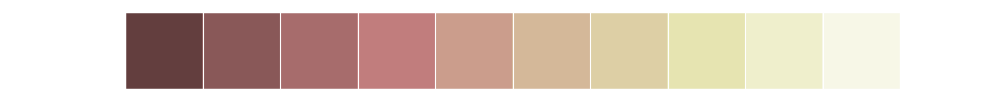

In [2]:
cmap_met = sns.cubehelix_palette(start=3, light=0.95, as_cmap=True)
cmap_ext = sns.cubehelix_palette(start=3.67, light=0.95, as_cmap=True)
cmap_sfr = sns.cubehelix_palette(start=2.0, light=0.88, dark=0.45, as_cmap=True)

sns.palplot(sns.color_palette("pink", 10))
as1063_color = sns.color_palette("pink", 10)[2]
a370_color  =  sns.color_palette("pink", 10)[5]
m1206_color =  sns.color_palette("pink", 10)[7]

Load data

In [3]:
as1063 = Table.read('as1063_fmz.dat',format='ascii.commented_header')
a370   = Table.read('a370_fmz.dat',format='ascii.commented_header')
m1206  = Table.read('macs1206_fmz.dat',format='ascii.commented_header')

Rearange MACS1206 data

In [4]:
m1206['Ha_flux_unc'] = m1206['Ha_flux_unc']/m1206['Ha_flux'] 
m1206['Ha_flux'] = np.log10(m1206['Ha_flux']*1e18)
m1206.remove_rows(np.where(np.isnan(m1206['met'])))
m1206.show_in_notebook()

## Make histogram of the size of the bins for the 3 galaxies

<IPython.core.display.Javascript object>


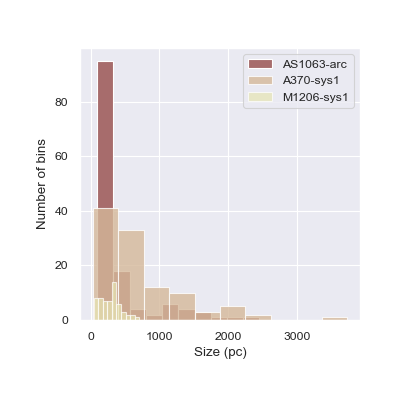

In [5]:
as1063_color = sns.color_palette("pink", 10)[2]
a370_color  =  sns.color_palette("pink", 10)[5]
m1206_color =  sns.color_palette("pink", 10)[7]

#sns.set(style='ticks')
fig, ax = plt.subplots(1,1,figsize=(4,4))
fig.subplots_adjust(left=0.2,bottom=0.2)
hist(np.sqrt(as1063['area_pc']),color=as1063_color,label='AS1063-arc')
hist(np.sqrt(a370['area_pc']),color=a370_color,label='A370-sys1',alpha=0.8)
hist(np.sqrt(m1206['area_pc']),color=m1206_color,label='M1206-sys1',alpha=0.7)

ax.legend()
ax.set_ylabel('Number of bins')
ax.set_xlabel('Size (pc)')

fig.savefig('../Plots/bin_sizes.pdf')

## Prepare fitting routines

We will use two fitting altorithms/codes:
    
    Linmix https://linmix.readthedocs.io/en/latest/
    Orthogonal distance regression (ODR, scipy) https://docs.scipy.org/doc/scipy/reference/odr.html

For Linmix, some of the fits resulted in an assymetric sample of parameters. I calculate the 'best' parameter choice plus the uncertainty taking the bin with the most counts (maximum likilihood) and taking the 68% interval around this value. 
Here I do some tests with a know gaussian to make sure its all reasonable.

Looks like with at a sample size of 10000 things go ok.


In [6]:
def calculate_errors(data,bins):
    
    actual_bins = [np.mean((bins[l],bins[l+1])) for l in range(len(bins)-1)]

    max_value = actual_bins[np.argmax(data)]

    # Lower end
    cumul = np.cumsum(data[:np.argmax(data)])
    cumul /= cumul[-1]
    low  = np.interp(0.68,cumul,actual_bins[:np.argmax(data)])

    # high end
    cumul = np.cumsum(data[np.argmax(data)+1:])
    cumul /= cumul[-1]
    high  = np.interp(0.68,cumul,actual_bins[np.argmax(data)+1:])
    
    return max_value, low, high

<IPython.core.display.Javascript object>


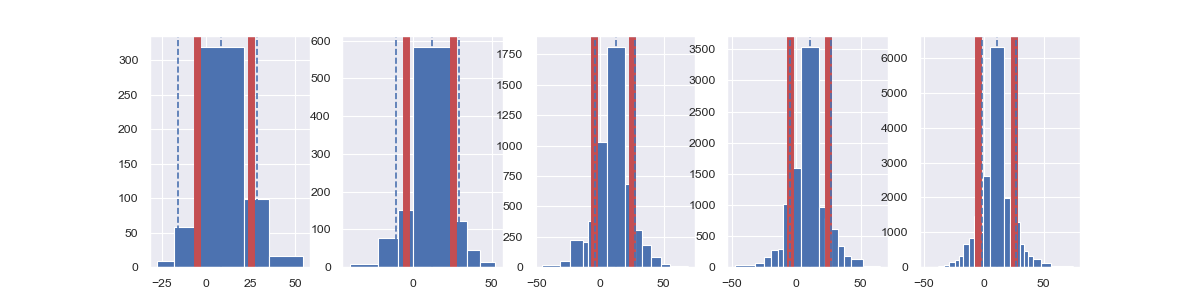

mean 10 8.206200361232373
var 15 22.181038157077246
mean 10 11.98380856321668
var 15 20.127621060206902
mean 10 12.807938366434898
var 15 15.74073845572426
mean 10 10.758972813034973
var 15 15.95451827104537
mean 10 10.988701137890182
var 15 14.281351714038411


<IPython.core.display.Javascript object>


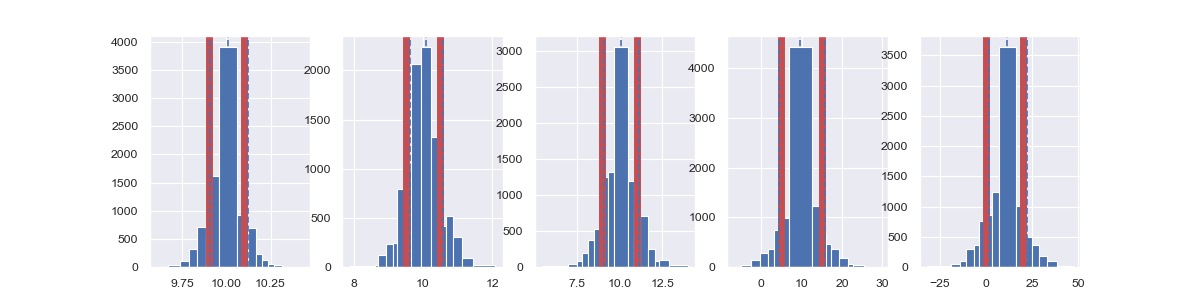

mean 10 10.009343610915064
var 0.1 0.10611800307080888
mean 10 10.08326535786637
var 0.5 0.4691304665196441
mean 10 10.089251143164365
var 1 0.9934461365914782
mean 10 9.631223603970597
var 5 5.6491158782011714
mean 10 11.543100102584948
var 10 10.38071904946958


In [7]:
def test(mean,var,size,ax):
    
    data = np.random.normal(loc=10,scale=var,size=size)

    ax.axvline(10-var,color='r',linewidth=5)
    ax.axvline(10+var,color='r',linewidth=5)

    n, bins,_ = hist(data,bins='blocks',ax=ax)

    alpha_max, alpha_low, alpha_high  = calculate_errors(n,bins)
    ax.axvline(alpha_max,linestyle='--')
    ax.axvline(alpha_low,linestyle='--')
    ax.axvline(alpha_high,linestyle='--')
    print('mean',mean,alpha_max)
    print('var',var,(alpha_high-alpha_low)/2)


# Changing normal size
fig, ax = plt.subplots(1,5,figsize=(12,3))
for x,s in zip(ax,(500,1000,5000,10000,20000)):
    test(10,15,s,x)
    
#Changing normal variance
fig, ax = plt.subplots(1,5,figsize=(12,3))
for x,s in zip(ax,(0.1,0.5,1,5,10)):
    test(10,s,10000,x)

Linmix 

In [55]:
def fit_with_linmix(data,ax,xlabel,ylabel,xs=np.arange(1,3.1,0.1),xnorm=0,annotate=True,seed=1):
    
    # Fit
    lm = linmix.LinMix(x = data[xlabel]-xnorm, y = data[ylabel], xsig = data[xlabel+'_unc'], ysig = data[ylabel+'_unc'],seed=seed) # added a seed so that it is reproducible
    lm.run_mcmc(silent=True)
    
    # Get best parameters and their errors
    fig2, ax2 = plt.subplots(1,2,figsize=(13,4))
    alpha_dist, alpha_bins,_ = hist(lm.chain['alpha'],bins='blocks',ax =ax2[0])
    alpha_best, alpha_low, alpha_high = calculate_errors(alpha_dist, alpha_bins)
    beta_dist, beta_bins,_ = hist(lm.chain['beta'],bins='blocks',ax=ax2[1])
    beta_best, beta_low, beta_high = calculate_errors(beta_dist, beta_bins)
    ax2[0].axvline(alpha_best,color='k',linewidth=2.)
    ax2[0].axvline(alpha_low,color='k',linestyle='--')
    ax2[0].axvline(alpha_high,color='k',linestyle='--')
    ax2[1].axvline(beta_best,color='k',linewidth=2.)
    ax2[1].axvline(beta_low,color='k',linestyle='--')
    ax2[1].axvline(beta_high,color='k',linestyle='--')
    
    print('Best alpha %0.2f; Mean alpha %0.2f'%(alpha_best,np.mean(lm.chain['alpha'])))
    print('Best beta %0.2f; Mean beta %0.2f'%(beta_best,np.mean(lm.chain['beta'])))
    ax2[0].axvline(np.mean(lm.chain['alpha']),color='red',linewidth=2.)
    ax2[0].axvline(np.mean(lm.chain['alpha'])-np.std(lm.chain['alpha']),color='red',linestyle='--')
    ax2[0].axvline(np.mean(lm.chain['alpha'])+np.std(lm.chain['alpha']),color='red',linestyle='--')
    ax2[1].axvline(np.mean(lm.chain['beta']),color='red',linewidth=2.)
    ax2[1].axvline(np.mean(lm.chain['beta'])-np.std(lm.chain['beta']),color='red',linestyle='--')
    ax2[1].axvline(np.mean(lm.chain['beta'])+np.std(lm.chain['beta']),color='red',linestyle='--')
    
    # Plot
    xs -= xnorm
    for i in np.random.randint(0,len(lm.chain),10):
        ys = lm.chain[i]['alpha'] +  lm.chain[i]['beta']* xs 
        ax.plot(xs + xnorm, ys, color='0.7', alpha=0.3,zorder=1,linewidth=2)
    ax.plot(xs+ xnorm,alpha_best + beta_best*xs, color='k',zorder=2)
    #ax.plot(xs,np.mean(lm.chain['alpha']) + np.mean(lm.chain['beta'])*xs, color='red',zorder=2)

    if annotate:
        bbox_props = dict(boxstyle="round", fc='w',ec="k", alpha=1)
        ax.annotate('%0.2f$^{+%0.2f}_{-%0.2f}$ + %0.2f$^{+%0.2f}_{-%0.2f}$ log($\\frac{\Sigma_{\star}}{%0.1f}$)'
                    %(alpha_best,alpha_high-alpha_best,alpha_best-alpha_low,beta_best,beta_high-beta_best,beta_best-beta_low,xnorm),
                    xy=(0.05, 0.865), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)
    
    print('Intrinsic scatter',np.mean(lm.chain['sigsqr']))
    return  alpha_best,alpha_low,alpha_high,beta_best,beta_low,beta_high

## Resolved Star-Forming Main Sequence

Published relations

In [11]:
def wuytz2013(logmass):
    return -8.4 + 0.95*logmass

def abdurrouf2018(logmass):
    return -8.31 + 0.88*logmass

def speagle2014(logmass,t):
    return - (6.51 -0.11*t) + (0.84 -0.026*t)*logmass 

'Normal' fit

<IPython.core.display.Javascript object>


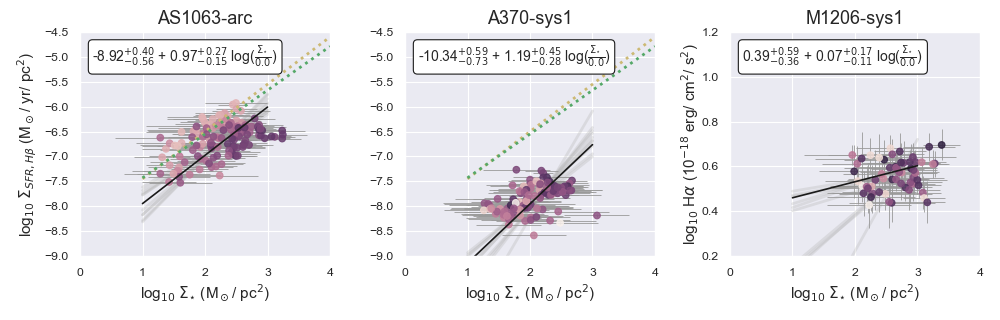

<IPython.core.display.Javascript object>


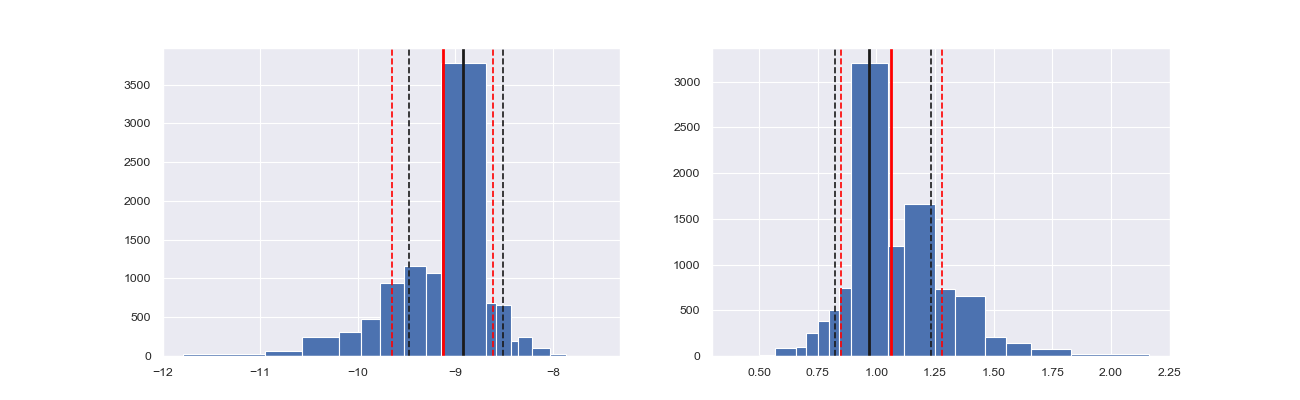

Best alpha -8.92; Mean alpha -9.13
Best beta 0.97; Mean beta 1.06
Intrinsic scatter 0.04378779491596505


<IPython.core.display.Javascript object>


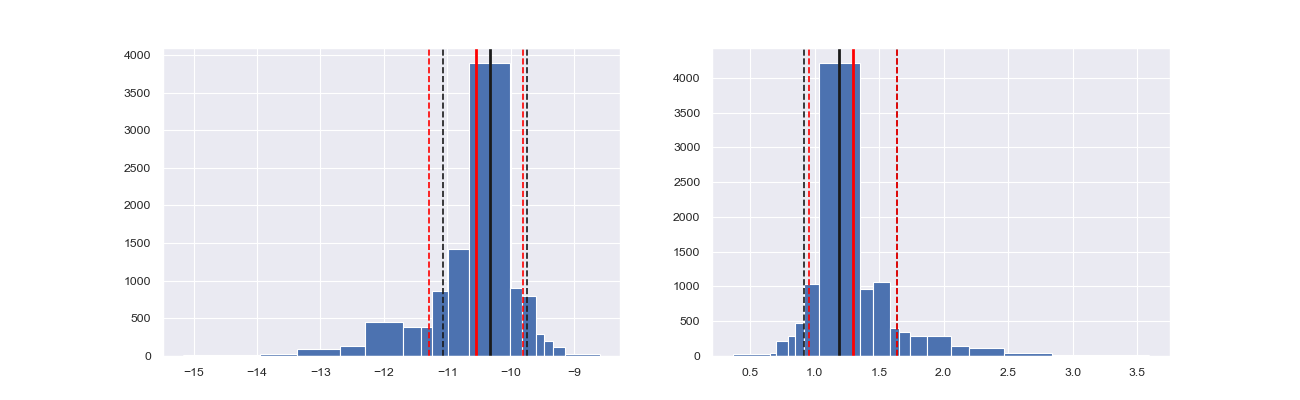

Best alpha -10.34; Mean alpha -10.55
Best beta 1.19; Mean beta 1.30
Intrinsic scatter 0.017939063602147205


<IPython.core.display.Javascript object>


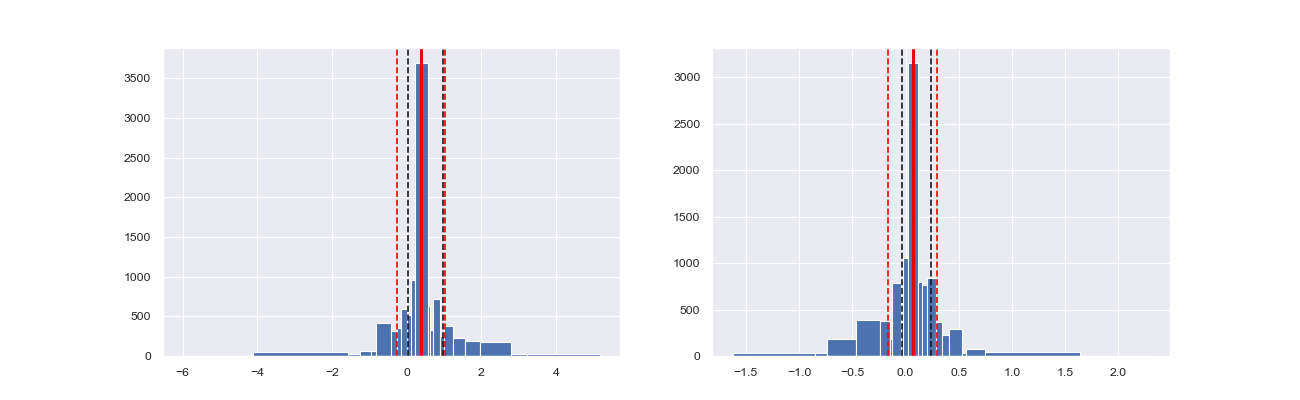

Best alpha 0.39; Mean alpha 0.38
Best beta 0.07; Mean beta 0.07
Intrinsic scatter 0.0008544154392536153


In [56]:
fig, ax = plt.subplots(1,3,figsize=(10,3.2))
fig.subplots_adjust(left=0.08,top=0.90,right=0.98,bottom=0.2,hspace=0.3,wspace=0.3)

## Plot data
ax[0].errorbar(as1063['mass_density'],as1063['sfr_density'],
               xerr = as1063['mass_density_unc'],yerr=as1063['sfr_density_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[0].scatter(as1063['mass_density'],as1063['sfr_density'], linewidths=None, alpha=0.85, marker='o', cmap=cmap_met, c=as1063['met'],zorder=2,vmin=8.65, vmax=9.05)
ax[1].errorbar(a370['mass_density'],a370['sfr_density'],
               xerr = a370['mass_density_unc'],yerr=a370['sfr_density_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
cax = ax[1].scatter(a370['mass_density'],a370['sfr_density'], linewidths=None, alpha=0.85, marker='o', cmap=cmap_met, c=a370['met'],zorder=2,vmin=8.65, vmax=9.05)

ax[2].errorbar(m1206['mass_density'],m1206['Ha_flux'],
               xerr = m1206['mass_density_unc'],yerr=m1206['Ha_flux_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
cax = ax[2].scatter(m1206['mass_density'],m1206['Ha_flux'], linewidths=None, alpha=0.85, marker='o', cmap=cmap_met, c=m1206['met'],zorder=2)


## Fit
seed = 1019
as1063_ms_fit = fit_with_linmix(as1063,ax[0],'mass_density','sfr_density',seed=seed)
a370_ms_fit = fit_with_linmix(a370,ax[1],'mass_density','sfr_density',seed=seed)
m1206_ms_fit = fit_with_linmix(m1206,ax[2],'mass_density','Ha_flux',seed=seed)


# Other published works
xs = np.arange(1,5) 
for x in ax[:2] :
    x.plot(xs,wuytz2013(xs),'y',zorder=10,label='Wuytz 2013',linestyle=':',linewidth=2)
    x.plot(xs,abdurrouf2018(xs),'g',zorder=10,label='Abdurro\'uf 2018',linestyle=':',linewidth=2)


## Legends and axis
ax[0].set_ylabel('log$_{10}$ $\Sigma_{SFR, H\\beta}$ (M$_\odot$/ yr/ pc$^2$)',fontsize='11')
ax[0].set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')

ax[1].set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')

ax[2].set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')
ax[2].set_ylabel('log$_{10}$ H$\\alpha$ (10$^{-18}$ erg/ cm$^2$/ s$^2$)',labelpad=0,fontsize='11')
ax[2].set_ylim(0.2,1.2)

for x in ax: x.set_xlim(0,4)
for x in ax[:2]: x.set_ylim(-9,-4.5)

ax[0].set_title('AS1063-arc',fontsize=13)    
ax[1].set_title('A370-sys1',fontsize=13)    
ax[2].set_title('M1206-sys1',fontsize=13)    
    
fig.savefig('../Plots/rSFMS_old.pdf')

**Centering data**

<IPython.core.display.Javascript object>


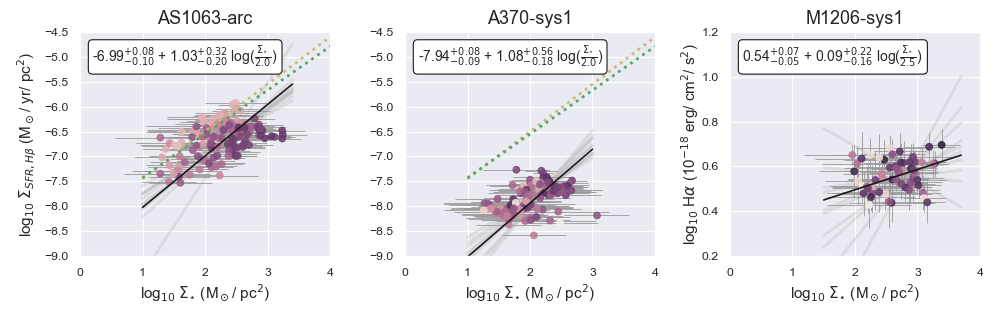

<IPython.core.display.Javascript object>


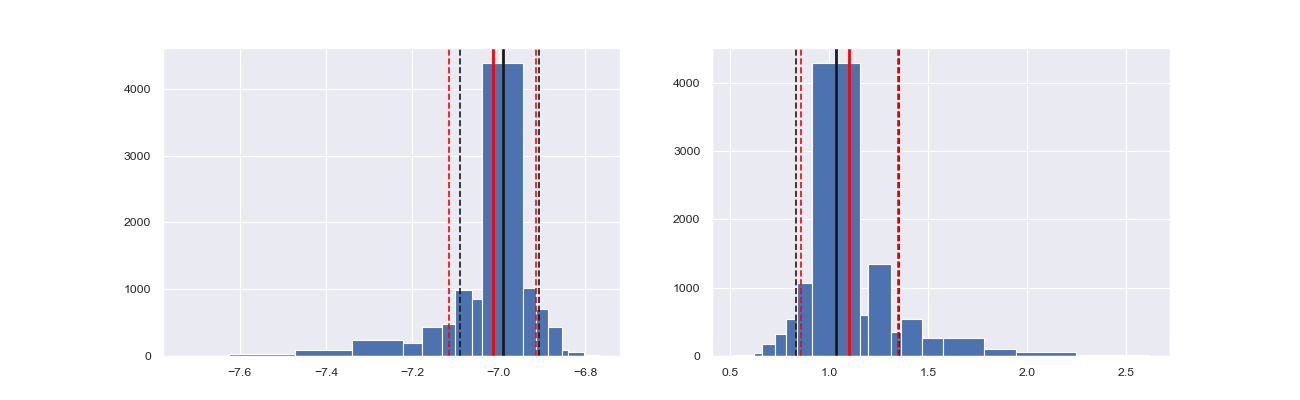

Best alpha -6.99; Mean alpha -7.01
Best beta 1.03; Mean beta 1.10
Intrinsic scatter 0.041440106815031914


<IPython.core.display.Javascript object>


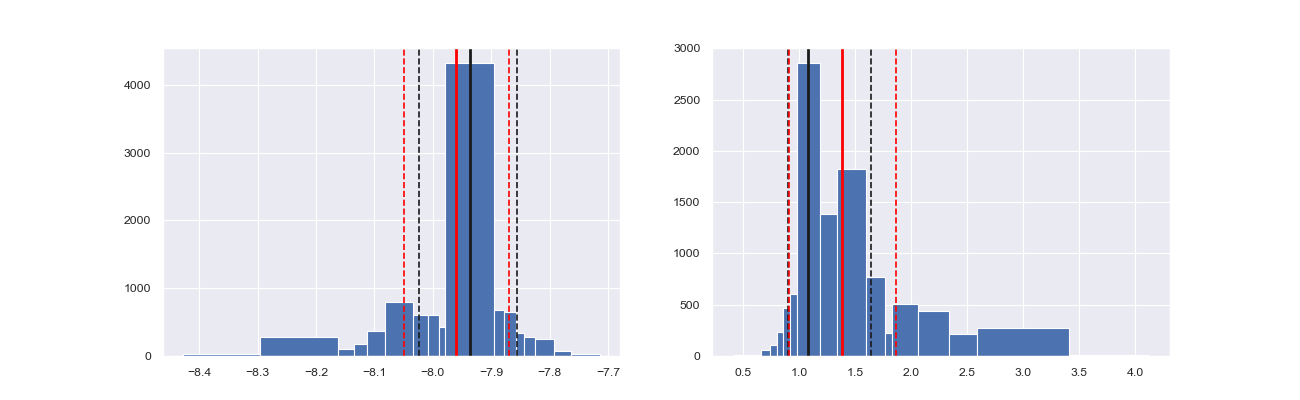

Best alpha -7.94; Mean alpha -7.96
Best beta 1.08; Mean beta 1.39
Intrinsic scatter 0.015493984441033141


<IPython.core.display.Javascript object>


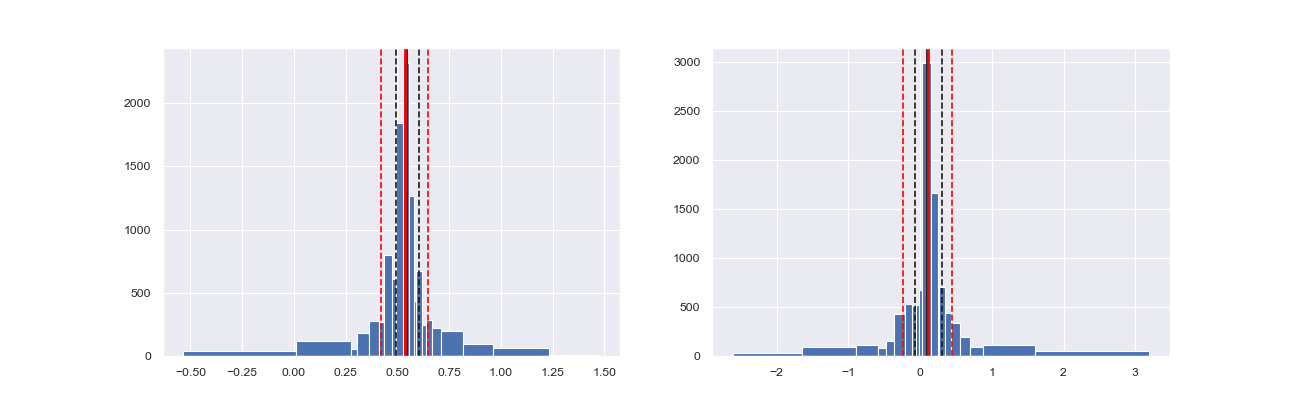

Best alpha 0.54; Mean alpha 0.53
Best beta 0.09; Mean beta 0.10
Intrinsic scatter 0.000881659946751034


In [57]:
fig, ax = plt.subplots(1,3,figsize=(10,3.2))
fig.subplots_adjust(left=0.08,top=0.90,right=0.98,bottom=0.2,hspace=0.3,wspace=0.3)

## Plot data
ax[0].errorbar(as1063['mass_density'],as1063['sfr_density'],
               xerr = as1063['mass_density_unc'],yerr=as1063['sfr_density_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[0].scatter(as1063['mass_density'],as1063['sfr_density'], linewidths=None, alpha=0.85, marker='o', cmap=cmap_met, c=as1063['met'],zorder=2,vmin=8.65, vmax=9.05)
ax[1].errorbar(a370['mass_density'],a370['sfr_density'],
               xerr = a370['mass_density_unc'],yerr=a370['sfr_density_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
cax = ax[1].scatter(a370['mass_density'],a370['sfr_density'], linewidths=None, alpha=0.85, marker='o', cmap=cmap_met, c=a370['met'],zorder=2,vmin=8.65, vmax=9.05)

ax[2].errorbar(m1206['mass_density'],m1206['Ha_flux'],
               xerr = m1206['mass_density_unc'],yerr=m1206['Ha_flux_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
cax = ax[2].scatter(m1206['mass_density'],m1206['Ha_flux'], linewidths=None, alpha=0.85, marker='o', cmap=cmap_met, c=m1206['met'],zorder=2)


## Fit
as1063_ms_fit_norm = fit_with_linmix(as1063,ax[0],'mass_density','sfr_density',xs=np.arange(1,3.5,0.1),seed=1014,xnorm=2.0)
a370_ms_fit_norm = fit_with_linmix(a370,ax[1],'mass_density','sfr_density',xs=np.arange(1,3.1,0.1),seed=1013,xnorm=2.0)
m1206_ms_fit_norm = fit_with_linmix(m1206,ax[2],'mass_density','Ha_flux',xs=np.arange(1.5,3.8,0.1),seed=1019,xnorm=2.5)

# Other published works
xs = np.arange(1,5)
for x in ax[:2] :
    x.plot(xs,wuytz2013(xs),'y',zorder=10,label='Wuytz 2013',linestyle=':',linewidth=2)
    x.plot(xs,abdurrouf2018(xs),'g',zorder=10,label='Abdurro\'uf 2018',linestyle=':',linewidth=2)


## Legends and axis
ax[0].set_ylabel('log$_{10}$ $\Sigma_{SFR, H\\beta}$ (M$_\odot$/ yr/ pc$^2$)',fontsize='11')
ax[0].set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')

ax[1].set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')

ax[2].set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')
ax[2].set_ylabel('log$_{10}$ H$\\alpha$ (10$^{-18}$ erg/ cm$^2$/ s$^2$)',labelpad=0,fontsize='11')
ax[2].set_ylim(0.2,1.2)

for x in ax: x.set_xlim(0,4)
for x in ax[:2]: x.set_ylim(-9,-4.5)

ax[0].set_title('AS1063-arc',fontsize=13)    
ax[1].set_title('A370-sys1',fontsize=13)    
ax[2].set_title('M1206-sys1',fontsize=13)    
    
fig.savefig('../Plots/rSFMS.pdf')

Published relations

In [58]:
def rosalesortega2012(logmass):
    return 8.079 + 0.525*logmass -0.098*logmass**2

def barreraballesteros2016(logmass):
    a,b,c = 8.55, 0.014, 3.14
    x = logmass 
    return a + b*(x - c) *np.exp(-(x-c))

def sanchez2013(logmass):
    a,b,c = 8.86, 0.097, 2.80
    x = logmass
    return a + b*(x - c)*np.exp(-(x-c))

Plot and fit each galaxy separatly

<IPython.core.display.Javascript object>


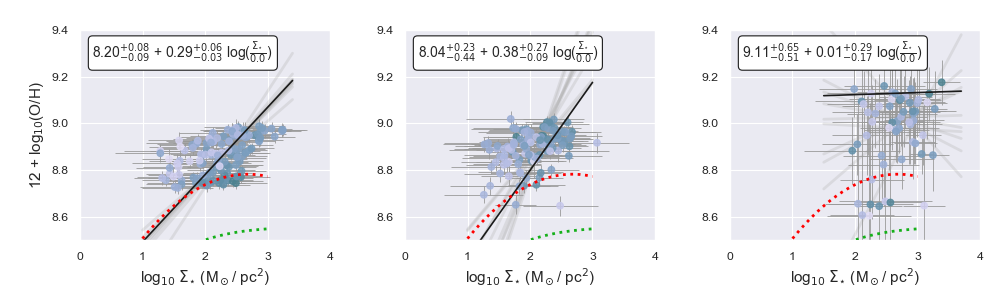

<IPython.core.display.Javascript object>


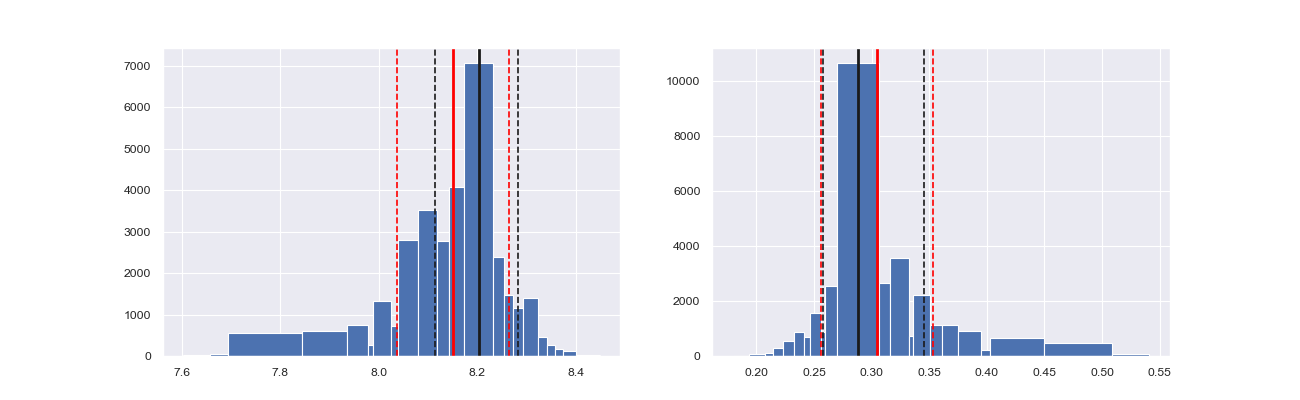

Best alpha 8.20; Mean alpha 8.15
Best beta 0.29; Mean beta 0.30
Intrinsic scatter 0.0001877880821943395


<IPython.core.display.Javascript object>


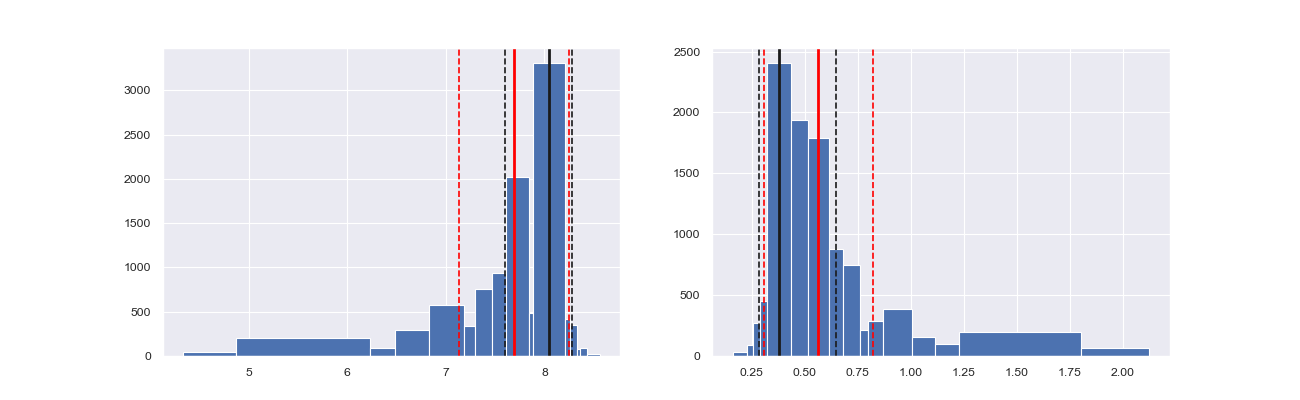

Best alpha 8.04; Mean alpha 7.69
Best beta 0.38; Mean beta 0.56
Intrinsic scatter 0.0006060413388420414


<IPython.core.display.Javascript object>


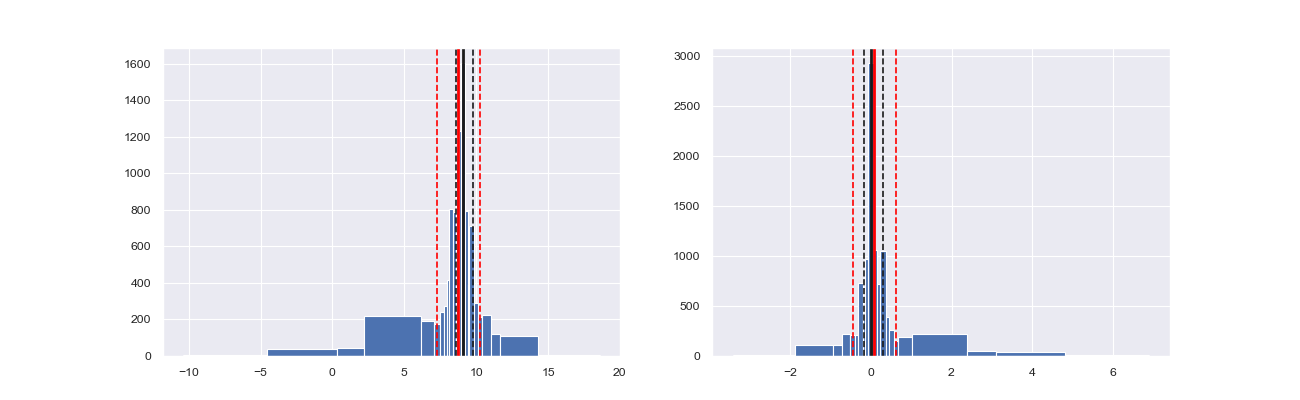

Best alpha 9.11; Mean alpha 8.76
Best beta 0.01; Mean beta 0.09
Intrinsic scatter 0.002031453375461446


In [59]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
fig.subplots_adjust(left=0.08,top=0.90,right=0.98,bottom=0.2,hspace=0.3,wspace=0.3)

## Plot data
ax[0].errorbar(as1063['mass_density'],as1063['met'],xerr = as1063['mass_density_unc'],yerr=as1063['met_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[0].scatter(as1063['mass_density'], as1063['met'], linewidths=None, alpha=0.85, marker='o', cmap=cmap_sfr, c=as1063['sfr_density'],zorder=2)
ax[1].errorbar(a370['mass_density'],a370['met'],xerr = a370['mass_density_unc'],yerr=a370['met_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
cax = ax[1].scatter(a370['mass_density'],a370['met'], linewidths=None, alpha=0.85, marker='o', cmap=cmap_sfr, c=a370['sfr_density'],zorder=2)
ax[2].errorbar(m1206['mass_density'],m1206['met'],xerr = m1206['mass_density_unc'],yerr=m1206['met_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[2].scatter(m1206['mass_density'],m1206['met'], linewidths=None, alpha=0.85, marker='o', cmap=cmap_sfr, c=m1206['Ha_flux'],zorder=2)


# Plot other works
xs = np.arange(1,3.1,0.1)
for x in ax:
    x.plot(xs,barreraballesteros2016(xs),'#15b01a',linestyle=':',zorder=10,label='Barrera (Manga)',linewidth=2)
    #x.plot(xs,sanchez2013(xs),'#f97306',zorder=10,linestyle=':',label='Sanchez (Califa)',linewidth=2)
    x.plot(xs,rosalesortega2012(xs),'red',zorder=10,linestyle=':',label='Rosales (Pings)',linewidth=2)
    
#ax[0].legend()

# Fit data
as1063_mzr_fit = fit_with_linmix(as1063,ax[0],'mass_density','met',seed=1017,xs=np.arange(1,3.5,0.1))
a370_mzr_fit = fit_with_linmix(a370,ax[1],'mass_density','met',seed=1019,xs=np.arange(1,3.1,0.1))
m1206_mzr_fit = fit_with_linmix(m1206,ax[2],'mass_density','met',seed=1001,xs=np.arange(1.5,3.8,0.1))


##Legends
ax[0].set_ylabel('12 + log$_{10}$(O/H)',fontsize='11')
for x in ax:
    x.set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')
    x.set_ylim(8.5,9.4)
    x.set_xlim(0,4)

fig.savefig('../Plots/rMZR_old.pdf')

**With centered data**

<IPython.core.display.Javascript object>


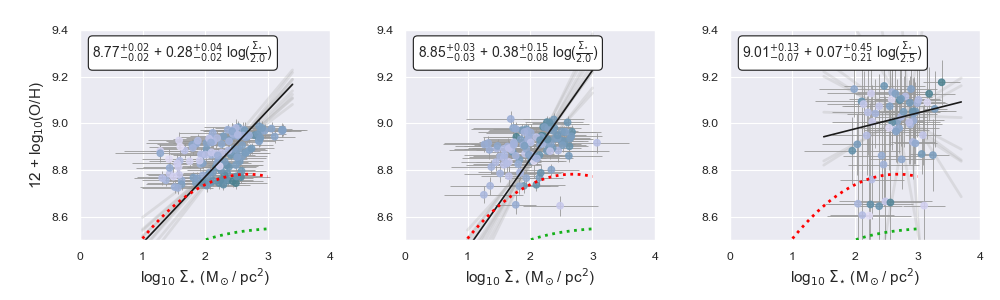

<IPython.core.display.Javascript object>


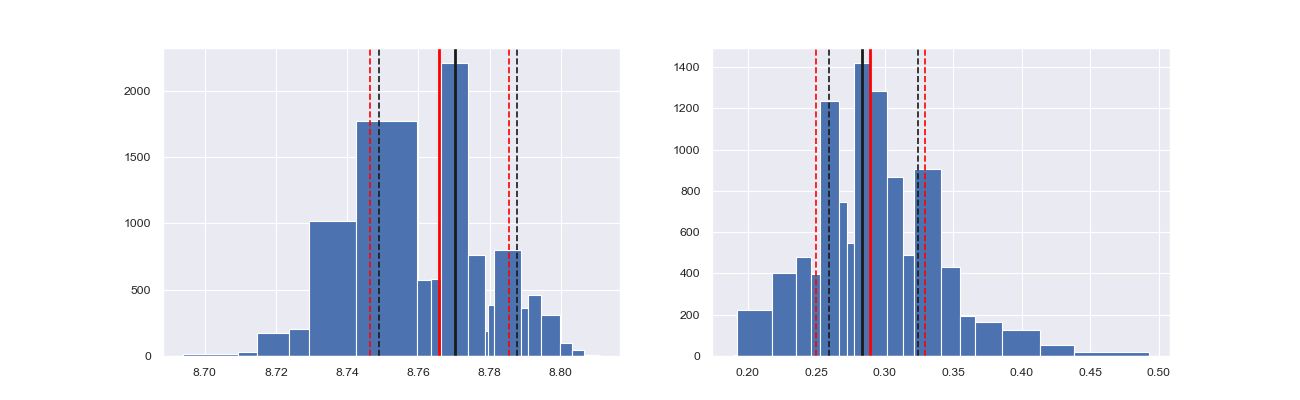

Best alpha 8.77; Mean alpha 8.77
Best beta 0.28; Mean beta 0.29
Intrinsic scatter 0.0001584380972898179


<IPython.core.display.Javascript object>


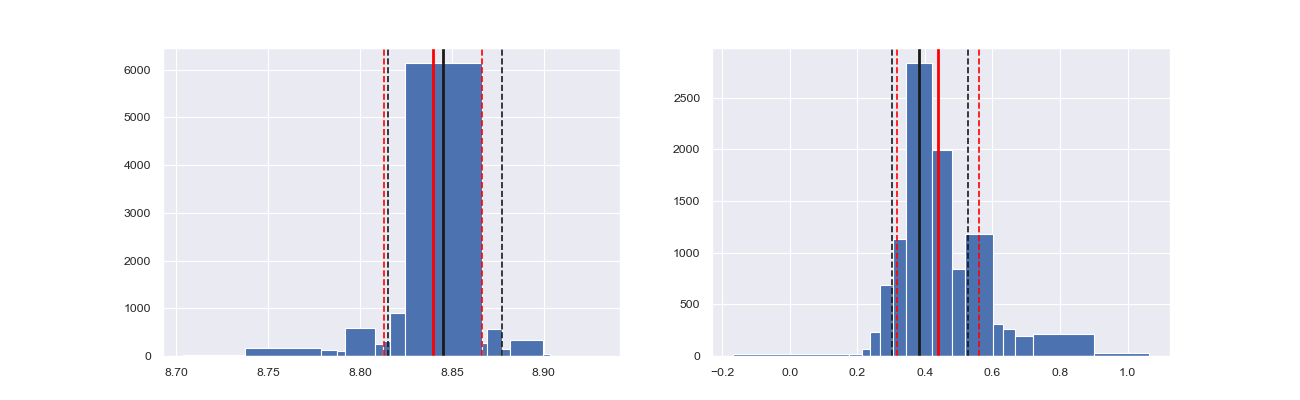

Best alpha 8.85; Mean alpha 8.84
Best beta 0.38; Mean beta 0.44
Intrinsic scatter 0.0005695404998090223


<IPython.core.display.Javascript object>


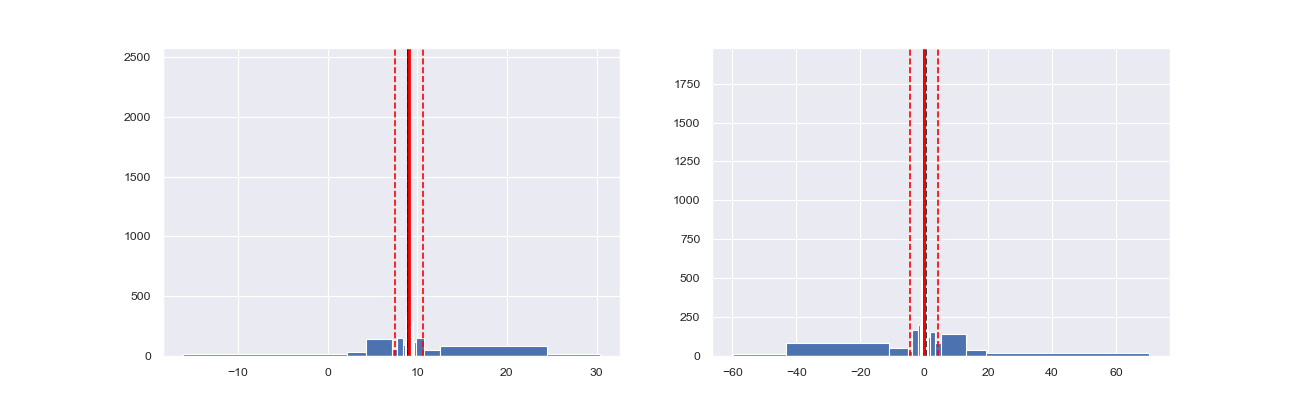

Best alpha 9.01; Mean alpha 9.07
Best beta 0.07; Mean beta -0.12
Intrinsic scatter 0.002012647632803397


In [60]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
fig.subplots_adjust(left=0.08,top=0.90,right=0.98,bottom=0.2,hspace=0.3,wspace=0.3)

## Plot data
ax[0].errorbar(as1063['mass_density'],as1063['met'],xerr = as1063['mass_density_unc'],yerr=as1063['met_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[0].scatter(as1063['mass_density'], as1063['met'], linewidths=None, alpha=0.85, marker='o', cmap=cmap_sfr, c=as1063['sfr_density'],zorder=2)
ax[1].errorbar(a370['mass_density'],a370['met'],xerr = a370['mass_density_unc'],yerr=a370['met_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
cax = ax[1].scatter(a370['mass_density'],a370['met'], linewidths=None, alpha=0.85, marker='o', cmap=cmap_sfr, c=a370['sfr_density'],zorder=2)
ax[2].errorbar(m1206['mass_density'],m1206['met'],xerr = m1206['mass_density_unc'],yerr=m1206['met_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[2].scatter(m1206['mass_density'],m1206['met'], linewidths=None, alpha=0.85, marker='o', cmap=cmap_sfr, c=m1206['Ha_flux'],zorder=2)


# Plot other works
xs = np.arange(1,3.1,0.1)
for x in ax:
    x.plot(xs,barreraballesteros2016(xs),'#15b01a',linestyle=':',zorder=10,label='Barrera (Manga)',linewidth=2)
    #x.plot(xs,sanchez2013(xs),'#f97306',zorder=10,linestyle=':',label='Sanchez (Califa)',linewidth=2)
    x.plot(xs,rosalesortega2012(xs),'red',zorder=10,linestyle=':',label='Rosales (Pings)',linewidth=2)
    
#ax[0].legend()

# Fit data
as1063_mzr_fit_norm = fit_with_linmix(as1063,ax[0],'mass_density','met',seed=1017,xnorm=2.0,xs=np.arange(1,3.5,0.1))
a370_mzr_fit_norm = fit_with_linmix(a370,ax[1],'mass_density','met',seed=1014,xnorm=2.0,xs=np.arange(1,3.1,0.1))
m1206_mzr_fit_norm = fit_with_linmix(m1206,ax[2],'mass_density','met',seed=1014,xnorm=2.5,xs=np.arange(1.5,3.8,0.1))


##Legends
ax[0].set_ylabel('12 + log$_{10}$(O/H)',fontsize='11')
for x in ax:
    x.set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')
    x.set_ylim(8.5,9.4)
    x.set_xlim(0,4)

fig.savefig('../Plots/rMZR.pdf')

## Resolved Fundamental Mass-Metallicity Relation

Here we explore if the residuals of the Mass-Metallicity relation are related with the SFR

In [61]:
def calculate_residuals_linmix(data,param,linmix_fit,xnorm=0):
    alpha,_,_,beta,_,_ = linmix_fit
    return data[param] - (alpha + beta*(data['mass_density']-xnorm))

def calculate_residuals_linmix_error(data,param,linmix_fit):
    alpha,alpha_high,alpha_low,beta,beta_high,beta_low = linmix_fit
    alpha_err = np.mean((alpha_high-alpha,alpha-alpha_low))
    beta_err = np.mean((beta_high-beta,beta-beta_low))
    return data[param+'_unc']+ alpha_err + data['mass_density']*beta_err + beta*data['mass_density_unc']

In [62]:
as1063['mzr_res'] =  calculate_residuals_linmix(as1063,'met',as1063_mzr_fit)
as1063['mzr_res_unc'] =  calculate_residuals_linmix_error(as1063,'met',as1063_mzr_fit)
as1063['ms_res'] =  calculate_residuals_linmix(as1063,'sfr_density',as1063_ms_fit)
as1063['ms_res_unc'] =  calculate_residuals_linmix_error(as1063,'sfr_density',as1063_ms_fit)

a370['mzr_res'] = calculate_residuals_linmix(a370,'met',a370_mzr_fit)
a370['mzr_res_unc'] = calculate_residuals_linmix_error(a370,'met',a370_mzr_fit)
a370['ms_res'] = calculate_residuals_linmix(a370,'sfr_density',a370_ms_fit)
a370['ms_res_unc'] = calculate_residuals_linmix_error(a370,'sfr_density',a370_ms_fit)

m1206['mzr_res'] = calculate_residuals_linmix(m1206,'met',m1206_mzr_fit)
m1206['mzr_res_unc'] = calculate_residuals_linmix_error(m1206,'met',m1206_mzr_fit)
m1206['ms_res'] = calculate_residuals_linmix(m1206,'Ha_flux',m1206_ms_fit)
m1206['ms_res_unc'] = calculate_residuals_linmix_error(m1206,'Ha_flux',m1206_ms_fit)

Only with spearman rank correlation

<IPython.core.display.Javascript object>


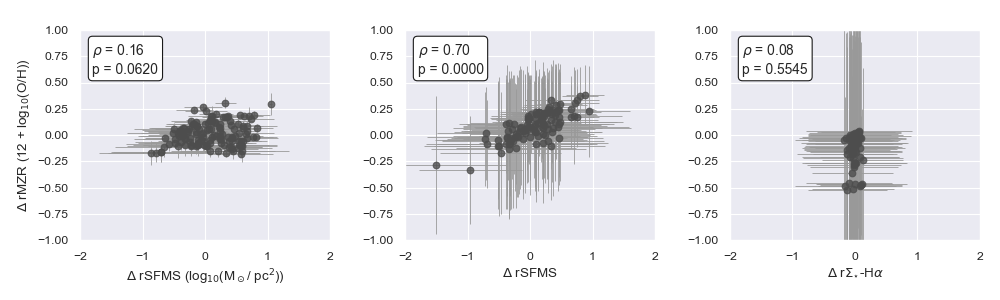

In [63]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
fig.subplots_adjust(left=0.08,top=0.90,right=0.98,bottom=0.2,hspace=0.3,wspace=0.3)

## Plot data
ax[0].errorbar(as1063['ms_res'],as1063['mzr_res'],yerr = as1063['mzr_res_unc'],xerr=as1063['ms_res_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[0].scatter(as1063['ms_res'], as1063['mzr_res'], linewidths=None, alpha=0.80, marker='o',color='0.3',zorder=2)

ax[1].errorbar(a370['ms_res'] ,a370['mzr_res'],yerr = a370['mzr_res_unc'],xerr = a370['ms_res_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[1].scatter(a370['ms_res'], a370['mzr_res'], linewidths=None, alpha=0.80, marker='o',color='0.3',zorder=2)

ax[2].errorbar(m1206['ms_res'],m1206['mzr_res'],yerr = m1206['mzr_res_unc'],xerr=m1206['ms_res_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[2].scatter(m1206['ms_res'], m1206['mzr_res'], linewidths=None, alpha=0.80, marker='o',color='0.3',zorder=2)


# Calculate correlation strengh 
from scipy.stats import spearmanr
bbox_props = dict(boxstyle="round", fc='w',ec="k", alpha=1)
def calculate_spearman(data,x):
    x.annotate('$\\rho$ = %0.2f\np = %0.4f'%spearmanr(data['ms_res'],data['mzr_res']),
                 xy=(0.05, 0.80), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)  
   
calculate_spearman(as1063,ax[0])
calculate_spearman(a370,ax[1])
calculate_spearman(m1206,ax[2])

# Legends and all
ax[0].set_xlabel('$\Delta$ rSFMS (log$_{10}$(M$_\odot$/ pc$^2$))')
ax[1].set_xlabel('$\Delta$ rSFMS')
ax[2].set_xlabel('$\Delta$ r$\Sigma_{\star}$-H$\\alpha$')

ax[0].set_ylabel('$\Delta$ rMZR (12 + log$_{10}$(O/H))')


for x in ax: x.set_ylim(-1.0,1.0)
for x in ax: x.set_xlim(-2.0,2.0)

fig.savefig('../Plots/res_rMZR_vs_rSFMS_spearman_old.pdf')

**With centered data**

In [64]:
as1063['mzr_res_norm'] =  calculate_residuals_linmix(as1063,'met',as1063_mzr_fit_norm,xnorm=2.0)
as1063['mzr_res_norm_unc'] =  calculate_residuals_linmix_error(as1063,'met',as1063_mzr_fit_norm)
as1063['ms_res_norm'] =  calculate_residuals_linmix(as1063,'sfr_density',as1063_ms_fit_norm,xnorm=2.0)
as1063['ms_res_norm_unc'] =  calculate_residuals_linmix_error(as1063,'sfr_density',as1063_ms_fit_norm)

a370['mzr_res_norm'] = calculate_residuals_linmix(a370,'met',a370_mzr_fit_norm,xnorm=2.0)
a370['mzr_res_norm_unc'] = calculate_residuals_linmix_error(a370,'met',a370_mzr_fit_norm)
a370['ms_res_norm'] = calculate_residuals_linmix(a370,'sfr_density',a370_ms_fit_norm,xnorm=2.0)
a370['ms_res_norm_unc'] = calculate_residuals_linmix_error(a370,'sfr_density',a370_ms_fit_norm)

m1206['mzr_res_norm'] = calculate_residuals_linmix(m1206,'met',m1206_mzr_fit_norm,xnorm=2.5)
m1206['mzr_res_norm_unc'] = calculate_residuals_linmix_error(m1206,'met',m1206_mzr_fit_norm)
m1206['ms_res_norm'] = calculate_residuals_linmix(m1206,'Ha_flux',m1206_ms_fit_norm,xnorm=2.5)
m1206['ms_res_norm_unc'] = calculate_residuals_linmix_error(m1206,'Ha_flux',m1206_ms_fit_norm)

<IPython.core.display.Javascript object>


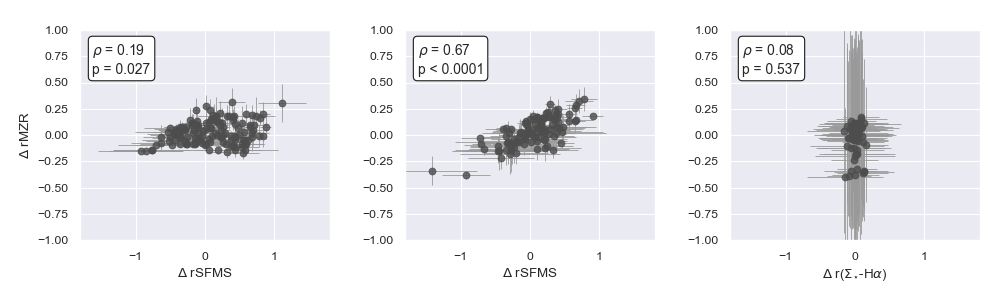

In [68]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
fig.subplots_adjust(left=0.08,top=0.90,right=0.98,bottom=0.2,hspace=0.3,wspace=0.3)

## Plot data
ax[0].errorbar(as1063['ms_res_norm'],as1063['mzr_res_norm'],yerr = as1063['mzr_res_norm_unc'],xerr=as1063['ms_res_norm_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[0].scatter(as1063['ms_res_norm'], as1063['mzr_res_norm'], linewidths=None, alpha=0.80, marker='o',color='0.3',zorder=2)

ax[1].errorbar(a370['ms_res_norm'] ,a370['mzr_res_norm'],yerr = a370['mzr_res_norm_unc'],xerr = a370['ms_res_norm_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[1].scatter(a370['ms_res_norm'], a370['mzr_res_norm'], linewidths=None, alpha=0.80, marker='o',color='0.3',zorder=2)

ax[2].errorbar(m1206['ms_res_norm'],m1206['mzr_res_norm'],yerr = m1206['mzr_res_norm_unc'],xerr=m1206['ms_res_norm_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[2].scatter(m1206['ms_res_norm'], m1206['mzr_res_norm'], linewidths=None, alpha=0.80, marker='o',color='0.3',zorder=2)


# Calculate correlation strengh 
from scipy.stats import spearmanr
bbox_props = dict(boxstyle="round", fc='w',ec="k", alpha=1)
def calculate_spearman(data,x):
    r, p = spearmanr(data['ms_res_norm'],data['mzr_res_norm'])
    if p>0.0001:
        x.annotate('$\\rho$ = %0.2f\np = %0.3f'%(r,p),
            xy=(0.05, 0.80), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)  
    else:
        x.annotate('$\\rho$ = %0.2f\np < 0.0001'%(r),
            xy=(0.05, 0.80), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)  

calculate_spearman(as1063,ax[0])
calculate_spearman(a370,ax[1])
calculate_spearman(m1206,ax[2])

# Legends and all
ax[0].set_xlabel('$\Delta$ rSFMS')
ax[1].set_xlabel('$\Delta$ rSFMS')
ax[2].set_xlabel('$\Delta$ r($\Sigma_{\star}$-H$\\alpha$)')

ax[0].set_ylabel('$\Delta$ rMZR')


for x in ax: x.set_ylim(-1.0,1.0)
for x in ax: x.set_xlim(-1.8,1.8)

fig.savefig('../Plots/res_rMZR_vs_rSFMS_spearman.pdf')

Secondary dependance on SFR

<IPython.core.display.Javascript object>


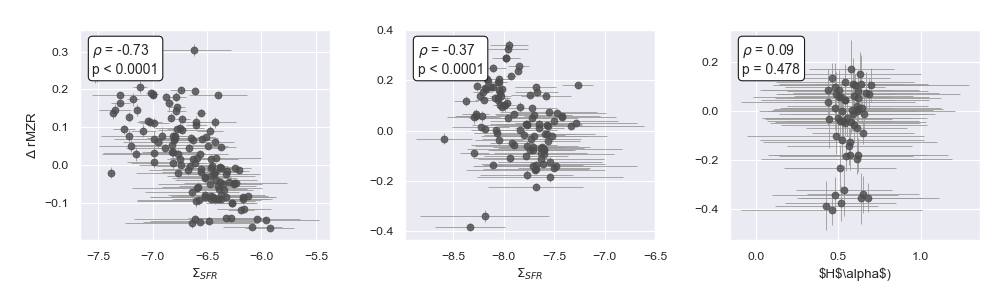

Text(0, 0.5, '$\\Delta$ rMZR')

In [73]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
fig.subplots_adjust(left=0.08,top=0.90,right=0.98,bottom=0.2,hspace=0.3,wspace=0.3)

## Plot data
ax[0].errorbar(as1063['sfr_density'],as1063['mzr_res_norm'],yerr = as1063['sfr_density_unc'],xerr=as1063['ms_res_norm_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[0].scatter(as1063['sfr_density'], as1063['mzr_res_norm'], linewidths=None, alpha=0.80, marker='o',color='0.3',zorder=2)

ax[1].errorbar(a370['sfr_density'] ,a370['mzr_res_norm'],yerr = a370['sfr_density_unc'],xerr = a370['ms_res_norm_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[1].scatter(a370['sfr_density'], a370['mzr_res_norm'], linewidths=None, alpha=0.80, marker='o',color='0.3',zorder=2)

ax[2].errorbar(m1206['Ha_flux'],m1206['mzr_res_norm'],yerr = m1206['Ha_flux_unc'],xerr=m1206['ms_res_norm_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[2].scatter(m1206['Ha_flux'], m1206['mzr_res_norm'], linewidths=None, alpha=0.80, marker='o',color='0.3',zorder=2)


# Calculate correlation strengh 
from scipy.stats import spearmanr
bbox_props = dict(boxstyle="round", fc='w',ec="k", alpha=1)
def calculate_spearman(data,x,cat):
    r, p = spearmanr(data[cat],data['mzr_res_norm'])
    if p>0.0001:
        x.annotate('$\\rho$ = %0.2f\np = %0.3f'%(r,p),
            xy=(0.05, 0.80), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)  
    else:
        x.annotate('$\\rho$ = %0.2f\np < 0.0001'%(r),
            xy=(0.05, 0.80), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)  

calculate_spearman(as1063,ax[0],'sfr_density')
calculate_spearman(a370,ax[1],'sfr_density')
calculate_spearman(m1206,ax[2],'Ha_flux')

# Legends and all
ax[0].set_xlabel('$\Sigma_{SFR}$')
ax[1].set_xlabel('$\Sigma_{SFR}$')
ax[2].set_xlabel('$H$\\alpha$)')

ax[0].set_ylabel('$\Delta$ rMZR')


#for x in ax: x.set_ylim(-1.0,1.0)
#for x in ax: x.set_xlim(-1.8,1.8)

#fig.savefig('../Plots/res_rMZR_vs_rSFMS_spearman.pdf')

<IPython.core.display.Javascript object>


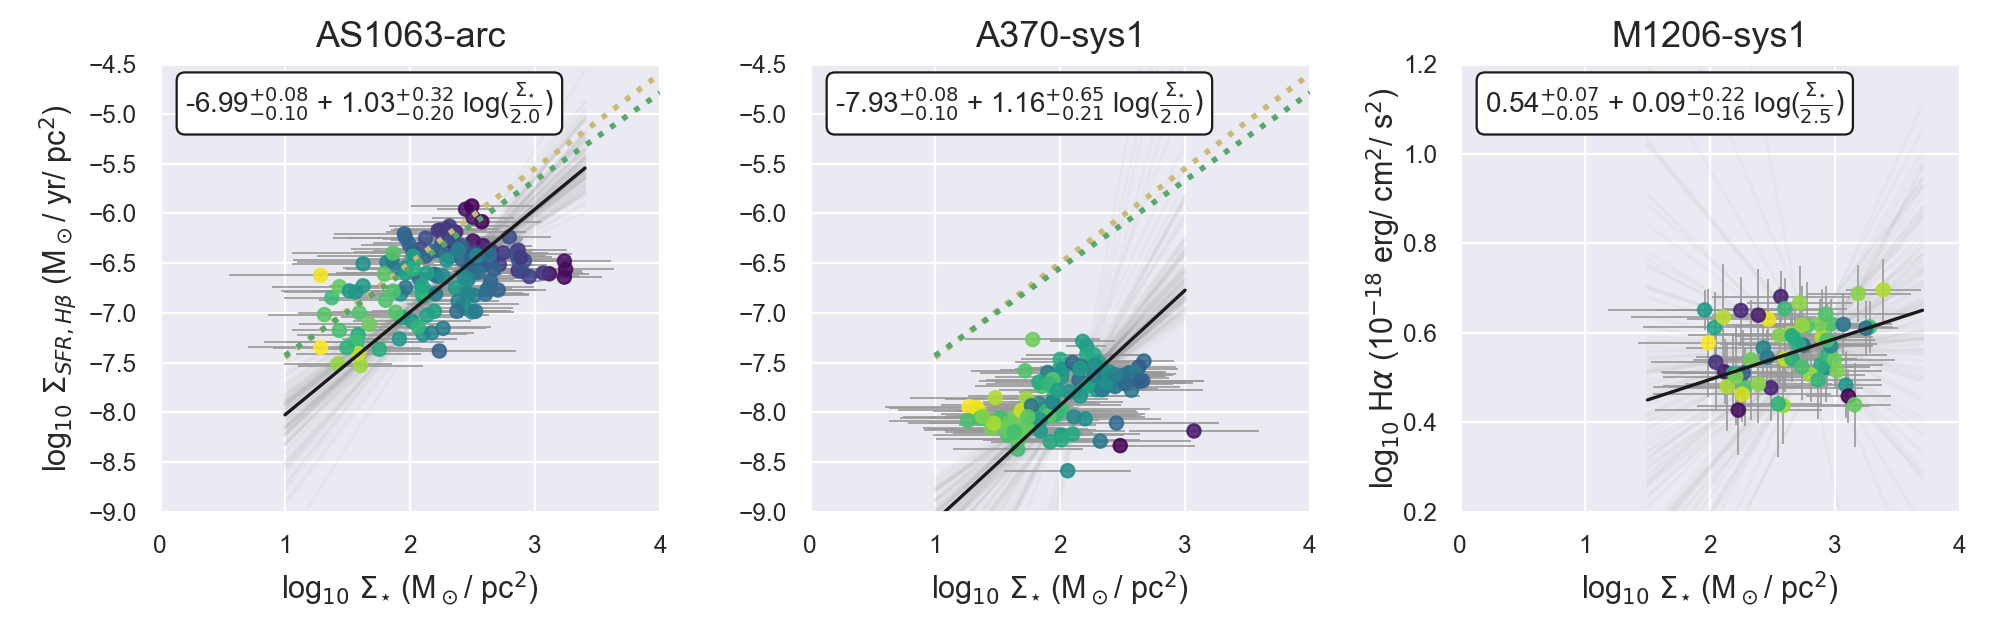

<IPython.core.display.Javascript object>


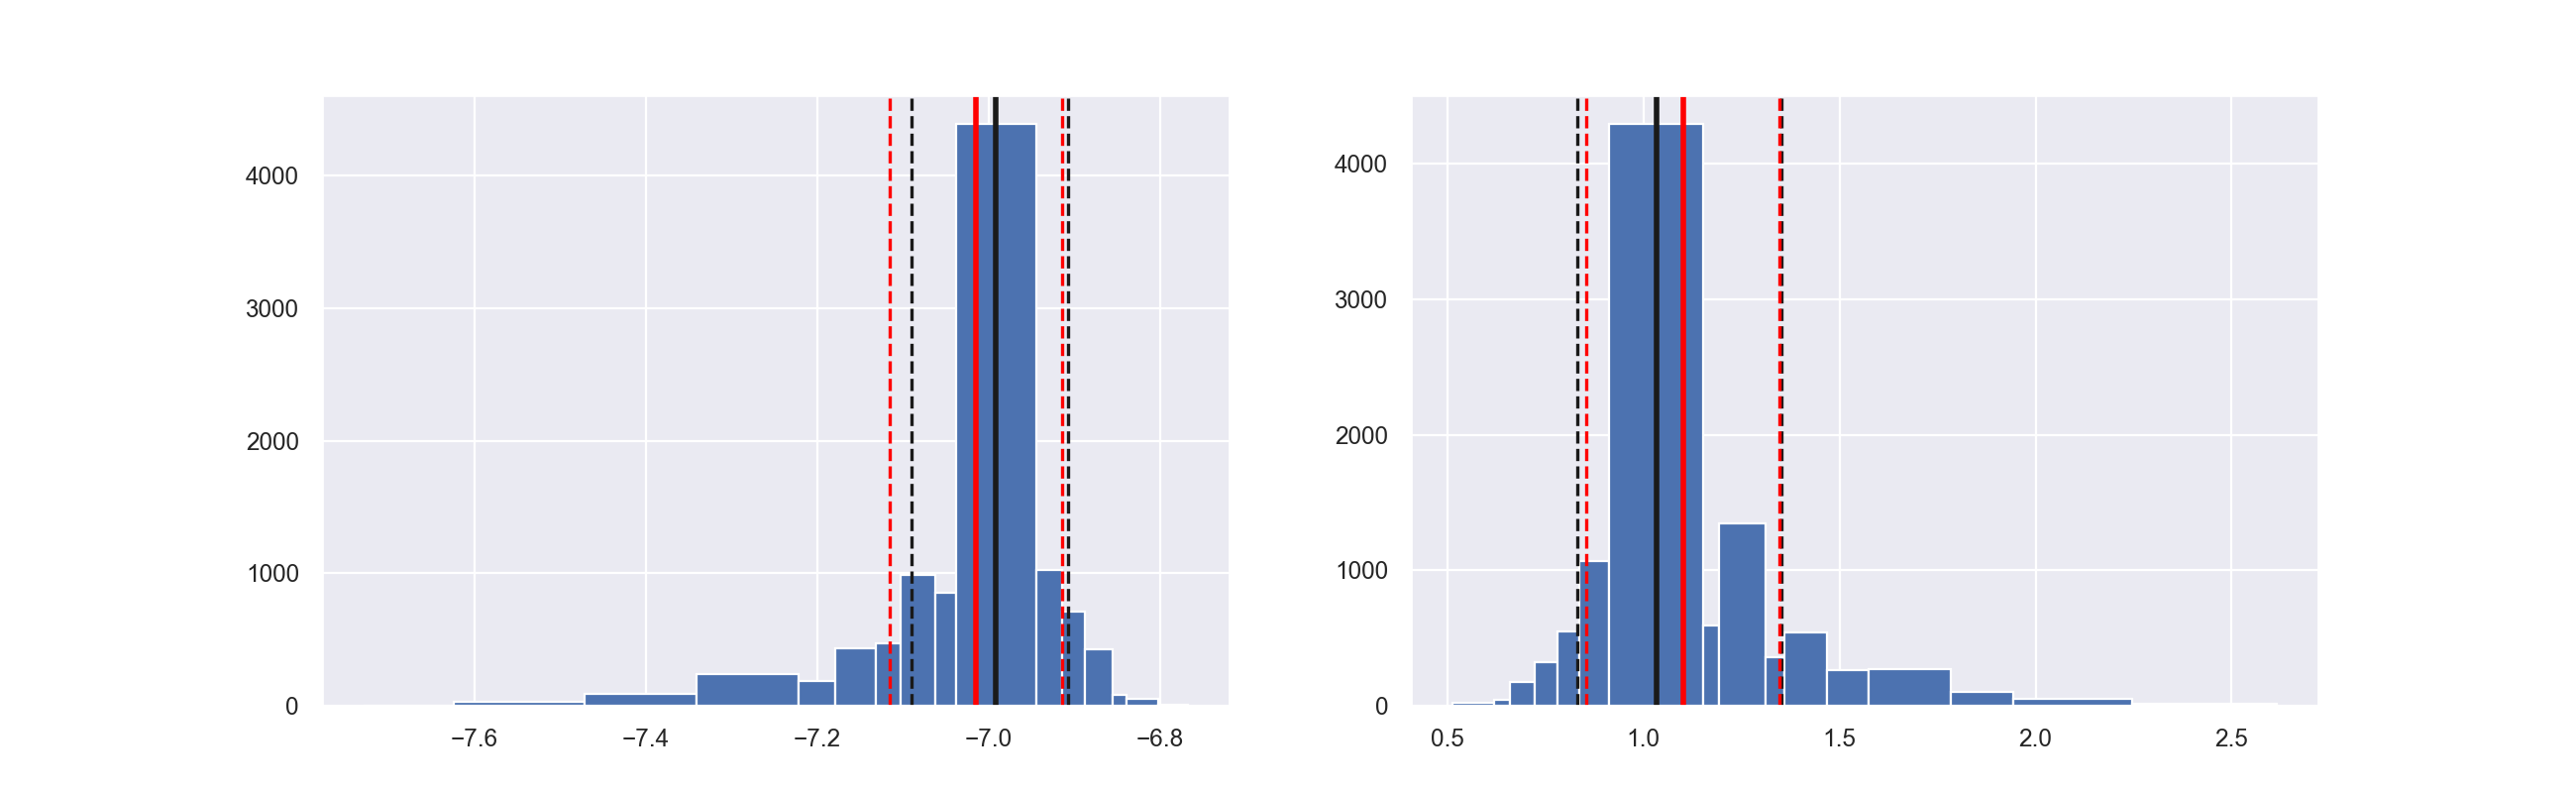

Best alpha -6.99; Mean alpha -7.01
Best beta 1.03; Mean beta 1.10
Intrinsic scatter 0.041440106815031914


<IPython.core.display.Javascript object>


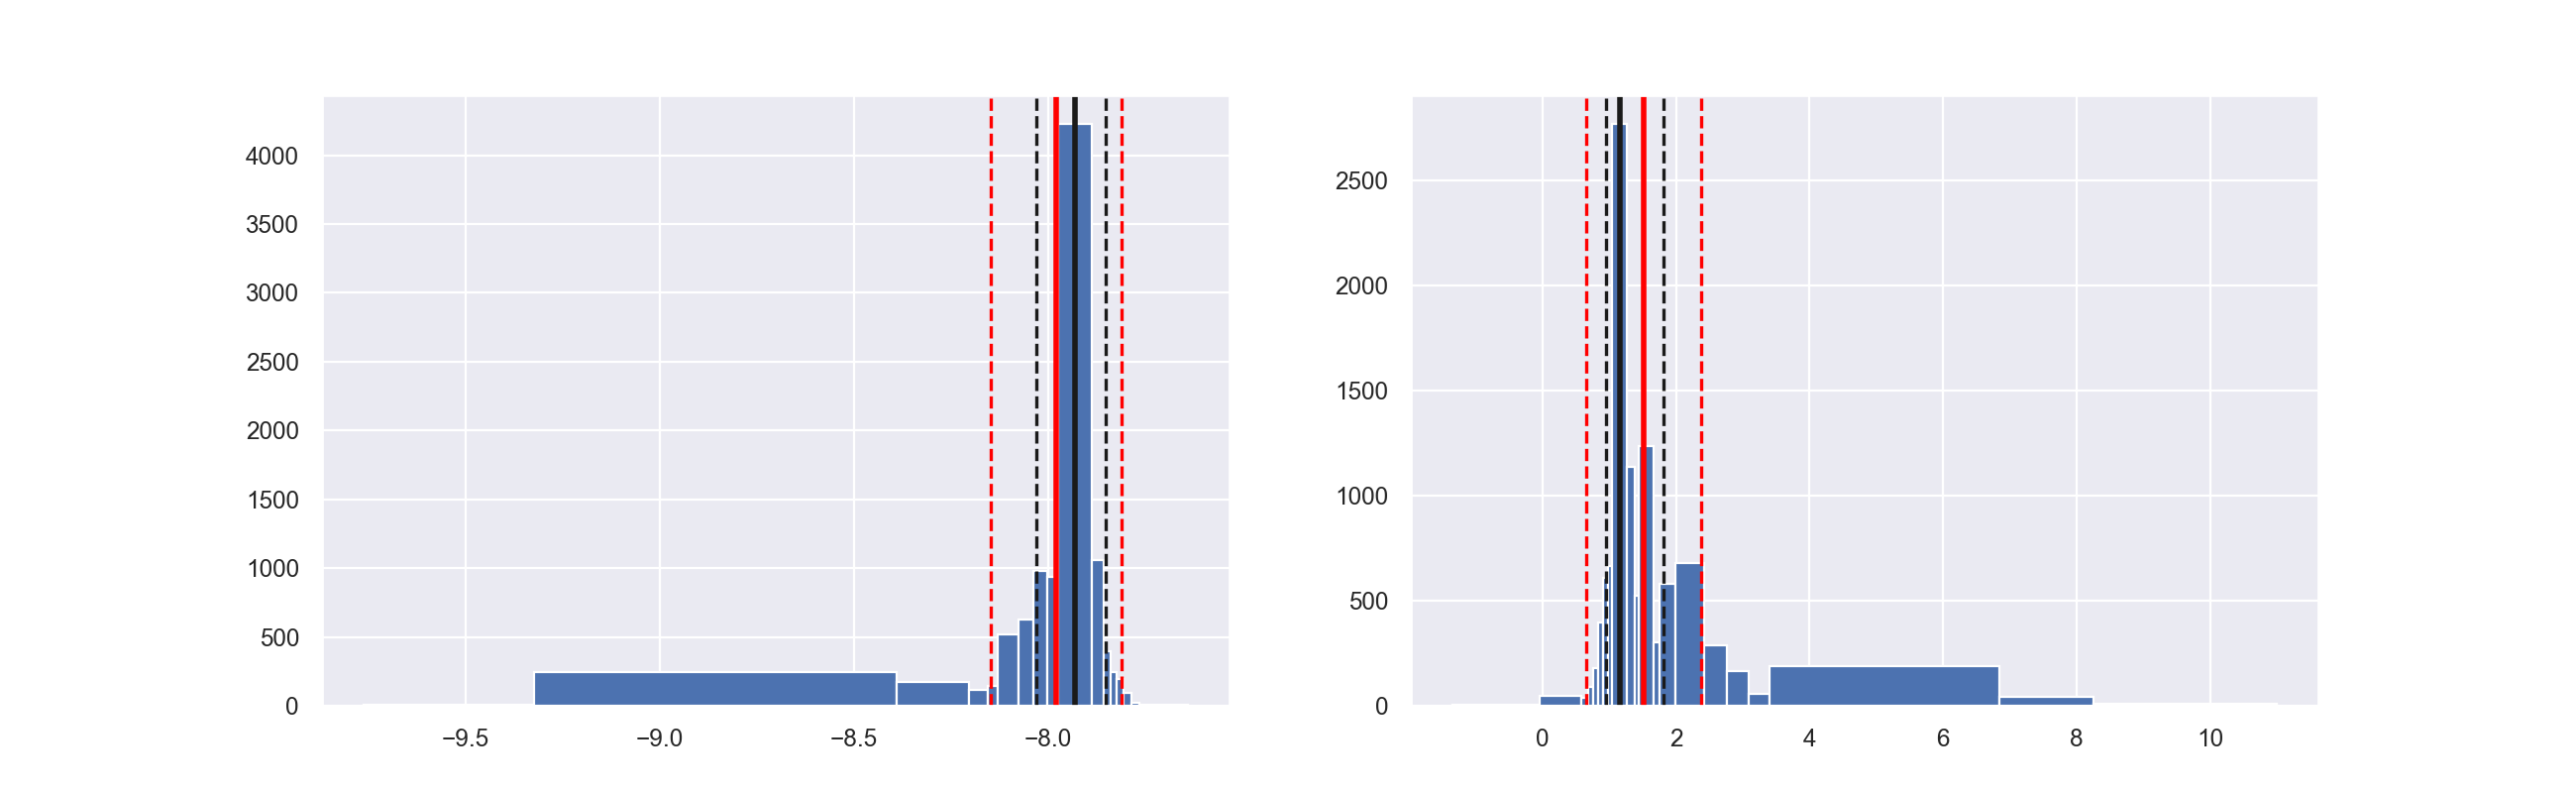

Best alpha -7.93; Mean alpha -7.98
Best beta 1.16; Mean beta 1.51
Intrinsic scatter 0.01787793680396483


<IPython.core.display.Javascript object>


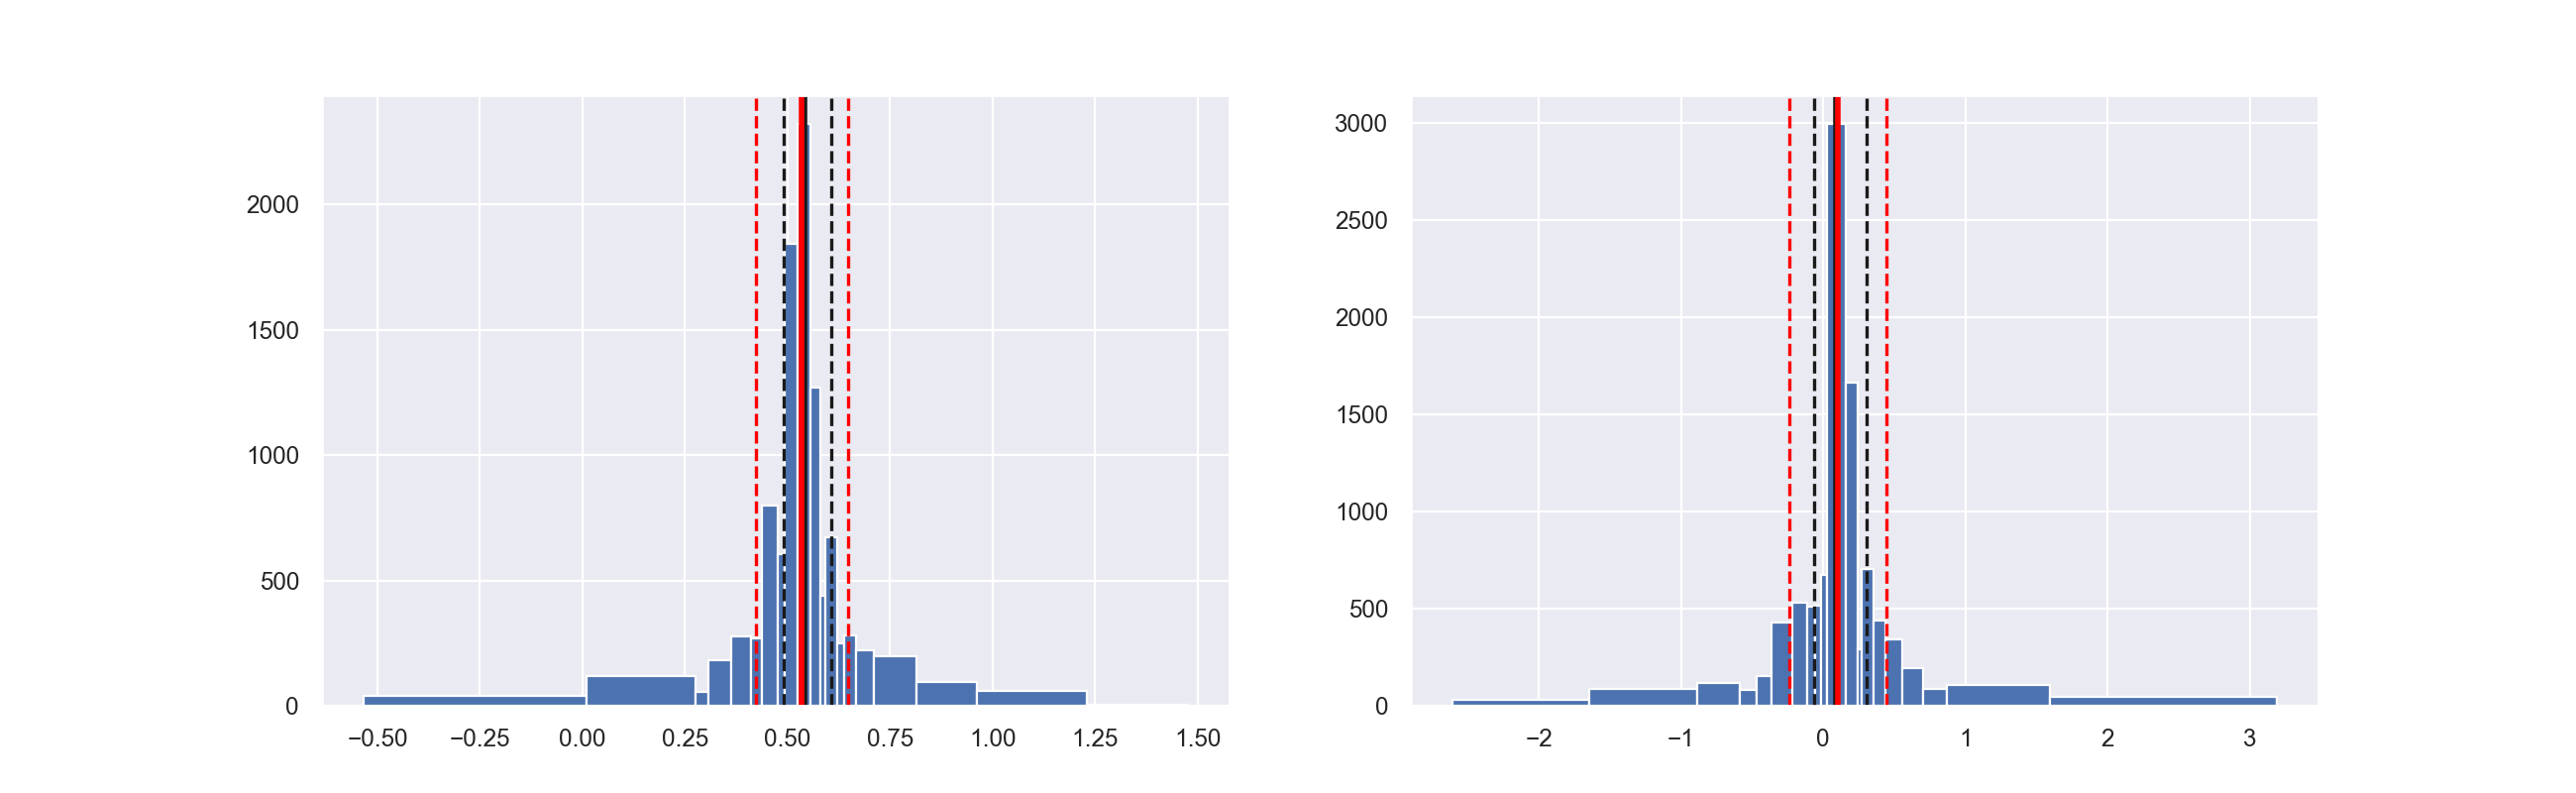

Best alpha 0.54; Mean alpha 0.53
Best beta 0.09; Mean beta 0.10
Intrinsic scatter 0.000881659946751034


Text(0.5, 1.0, 'M1206-sys1')

In [144]:
fig, ax = plt.subplots(1,3,figsize=(10,3.2))
fig.subplots_adjust(left=0.08,top=0.90,right=0.98,bottom=0.2,hspace=0.3,wspace=0.3)

## Plot data
ax[0].errorbar(as1063['mass_density'],as1063['sfr_density'],
               xerr = as1063['mass_density_unc'],yerr=as1063['sfr_density_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[0].scatter(as1063['mass_density'],as1063['sfr_density'], linewidths=None, alpha=0.85, marker='o', c=as1063['mzr_res_norm'],zorder=2,cmap='viridis')
ax[1].errorbar(a370['mass_density'],a370['sfr_density'],
               xerr = a370['mass_density_unc'],yerr=a370['sfr_density_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
cax = ax[1].scatter(a370['mass_density'],a370['sfr_density'], linewidths=None, alpha=0.85, marker='o', c=a370['mzr_res_norm'],zorder=2,cmap='viridis')

ax[2].errorbar(m1206['mass_density'],m1206['Ha_flux'],
               xerr = m1206['mass_density_unc'],yerr=m1206['Ha_flux_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
cax = ax[2].scatter(m1206['mass_density'],m1206['Ha_flux'], linewidths=None, alpha=0.85, marker='o', c=m1206['mzr_res_norm'],zorder=2,cmap='viridis')

## Fit
as1063_ms_fit_norm = fit_with_linmix_tests(as1063,ax[0],'mass_density','sfr_density',xs=np.arange(1,3.5,0.1),seed=1014,xnorm=2.0)
a370_ms_fit_norm = fit_with_linmix_tests(a370,ax[1],'mass_density','sfr_density',xs=np.arange(1,3.1,0.1),seed=1016,xnorm=2.0)
m1206_ms_fit_norm = fit_with_linmix_tests(m1206,ax[2],'mass_density','Ha_flux',xs=np.arange(1.5,3.8,0.1),seed=1019,xnorm=2.5)

# Other published works
xs = np.arange(1,5)
for x in ax[:2] :
    x.plot(xs,wuytz2013(xs),'y',zorder=10,label='Wuytz 2013',linestyle=':',linewidth=2)
    x.plot(xs,abdurrouf2018(xs),'g',zorder=10,label='Abdurro\'uf 2018',linestyle=':',linewidth=2)


## Legends and axis
ax[0].set_ylabel('log$_{10}$ $\Sigma_{SFR, H\\beta}$ (M$_\odot$/ yr/ pc$^2$)',fontsize='11')
ax[0].set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')

ax[1].set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')

ax[2].set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')
ax[2].set_ylabel('log$_{10}$ H$\\alpha$ (10$^{-18}$ erg/ cm$^2$/ s$^2$)',labelpad=0,fontsize='11')
ax[2].set_ylim(0.2,1.2)

for x in ax: x.set_xlim(0,4)
for x in ax[:2]: x.set_ylim(-9,-4.5)

ax[0].set_title('AS1063-arc',fontsize=13)    
ax[1].set_title('A370-sys1',fontsize=13)    
ax[2].set_title('M1206-sys1',fontsize=13)    

<IPython.core.display.Javascript object>


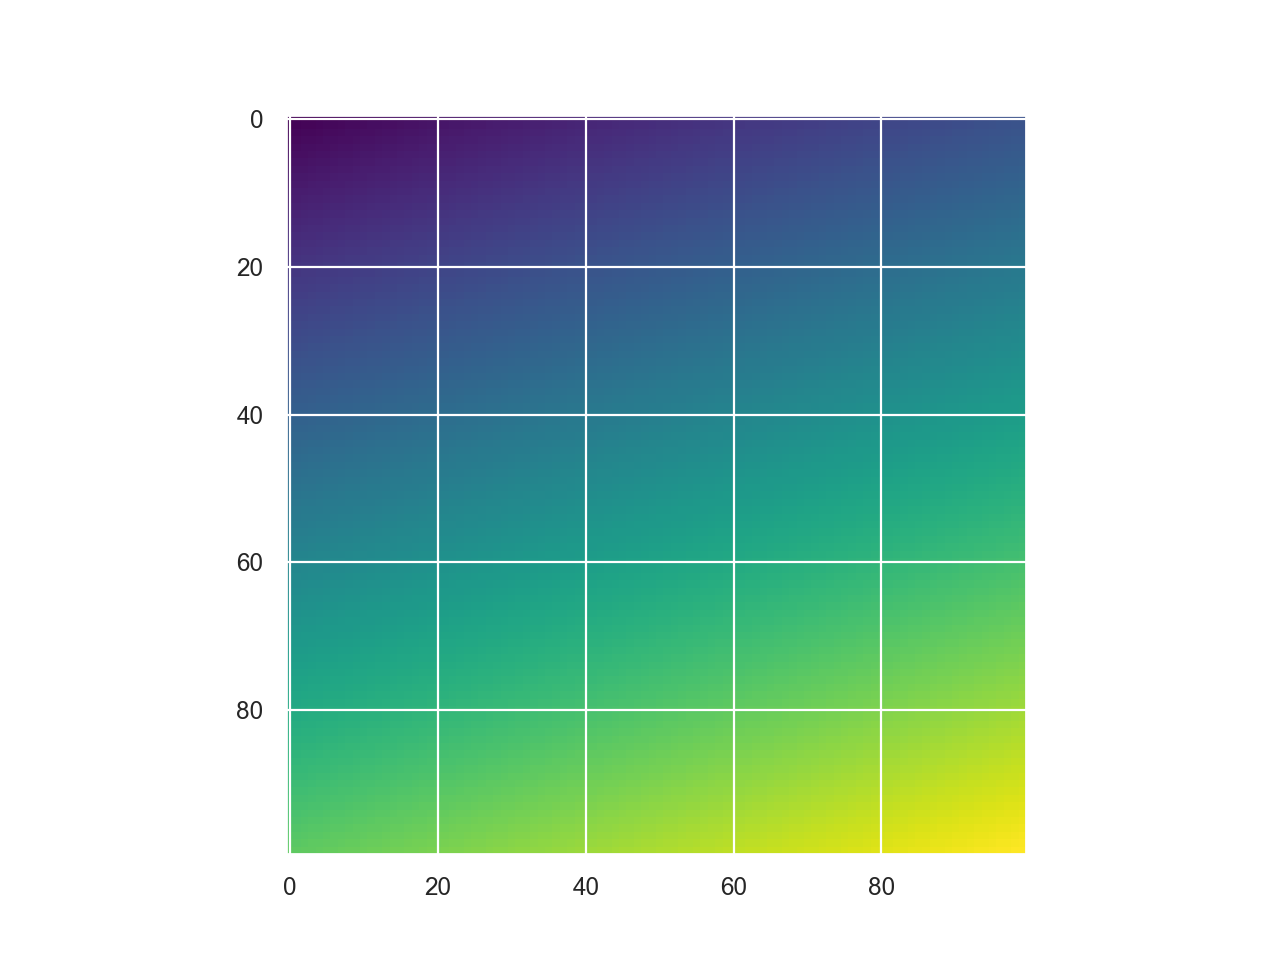

In [145]:
plt.figure()
plt.imshow(im,cmap='viridis')

In [ ]:
TEST to see if I'm plotting things right

<IPython.core.display.Javascript object>


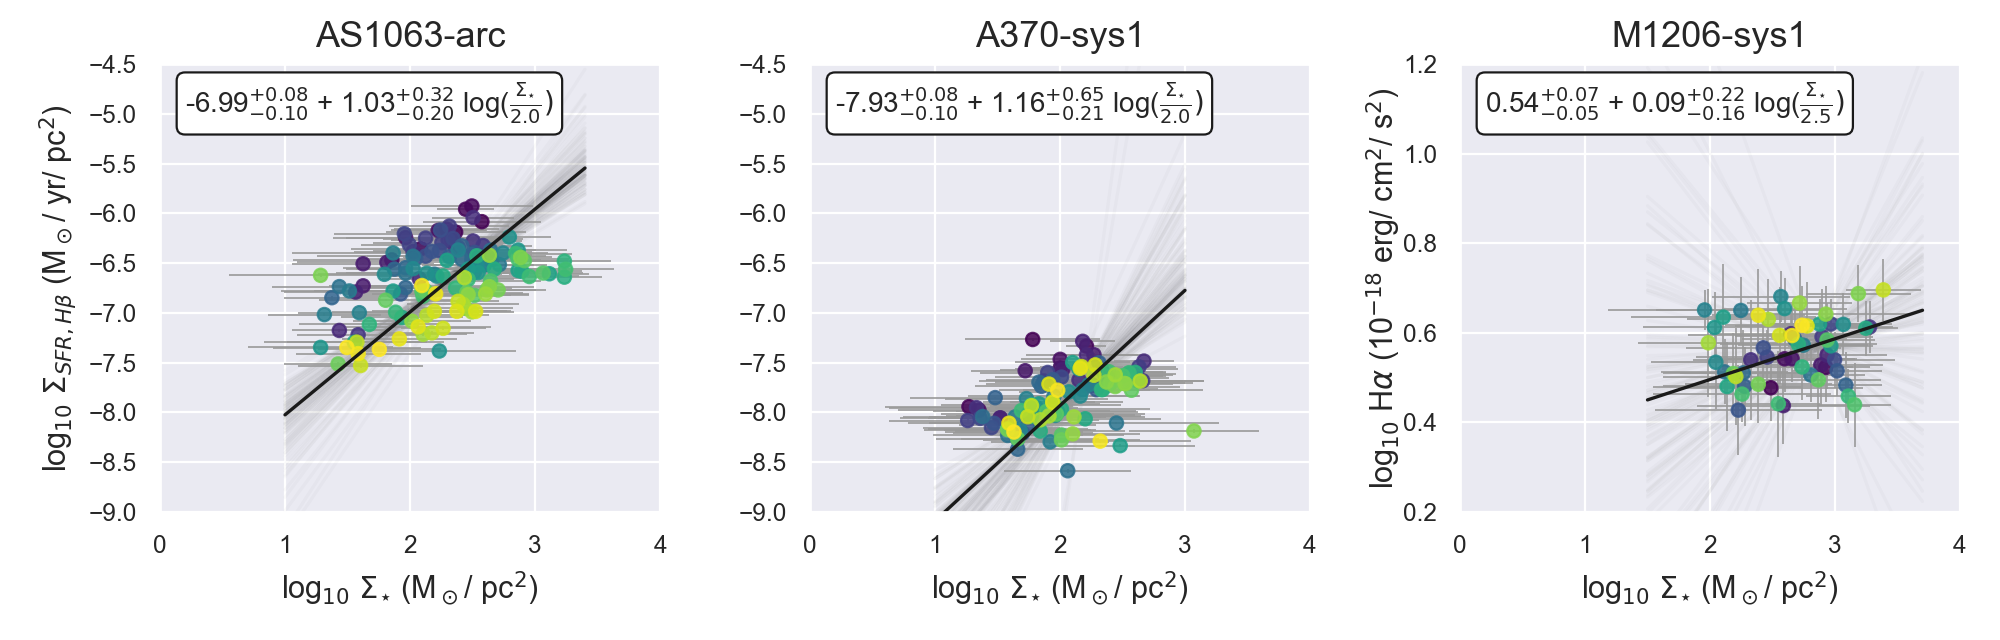

<IPython.core.display.Javascript object>

Best alpha -6.99; Mean alpha -7.01
Best beta 1.03; Mean beta 1.10
Intrinsic scatter 0.041440106815031914


<IPython.core.display.Javascript object>

Best alpha -7.93; Mean alpha -7.98
Best beta 1.16; Mean beta 1.51
Intrinsic scatter 0.01787793680396483


<IPython.core.display.Javascript object>

Best alpha 0.54; Mean alpha 0.53
Best beta 0.09; Mean beta 0.10
Intrinsic scatter 0.000881659946751034


<IPython.core.display.Javascript object>


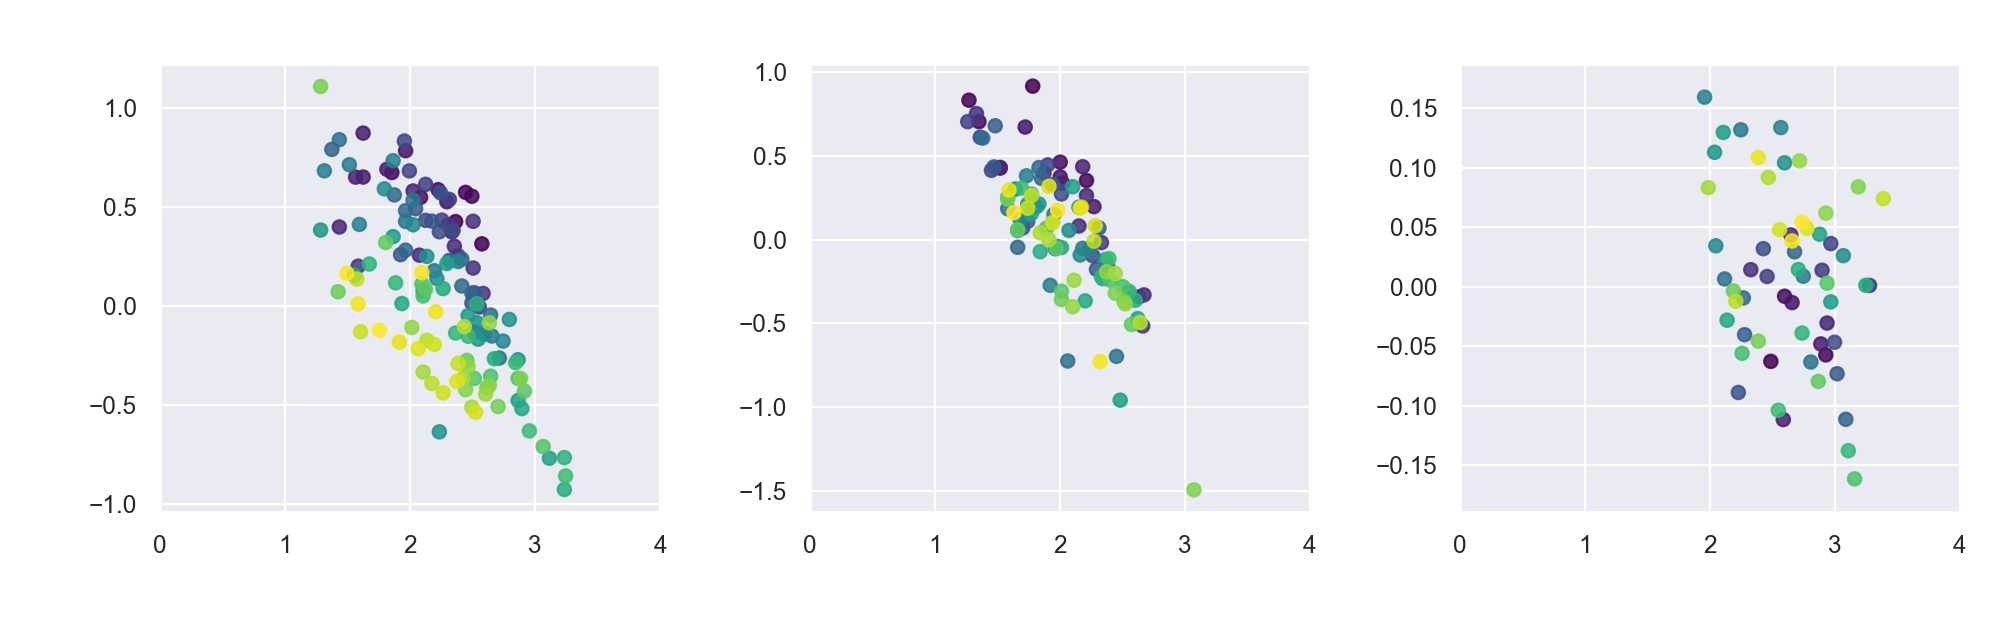

<IPython.core.display.Javascript object>


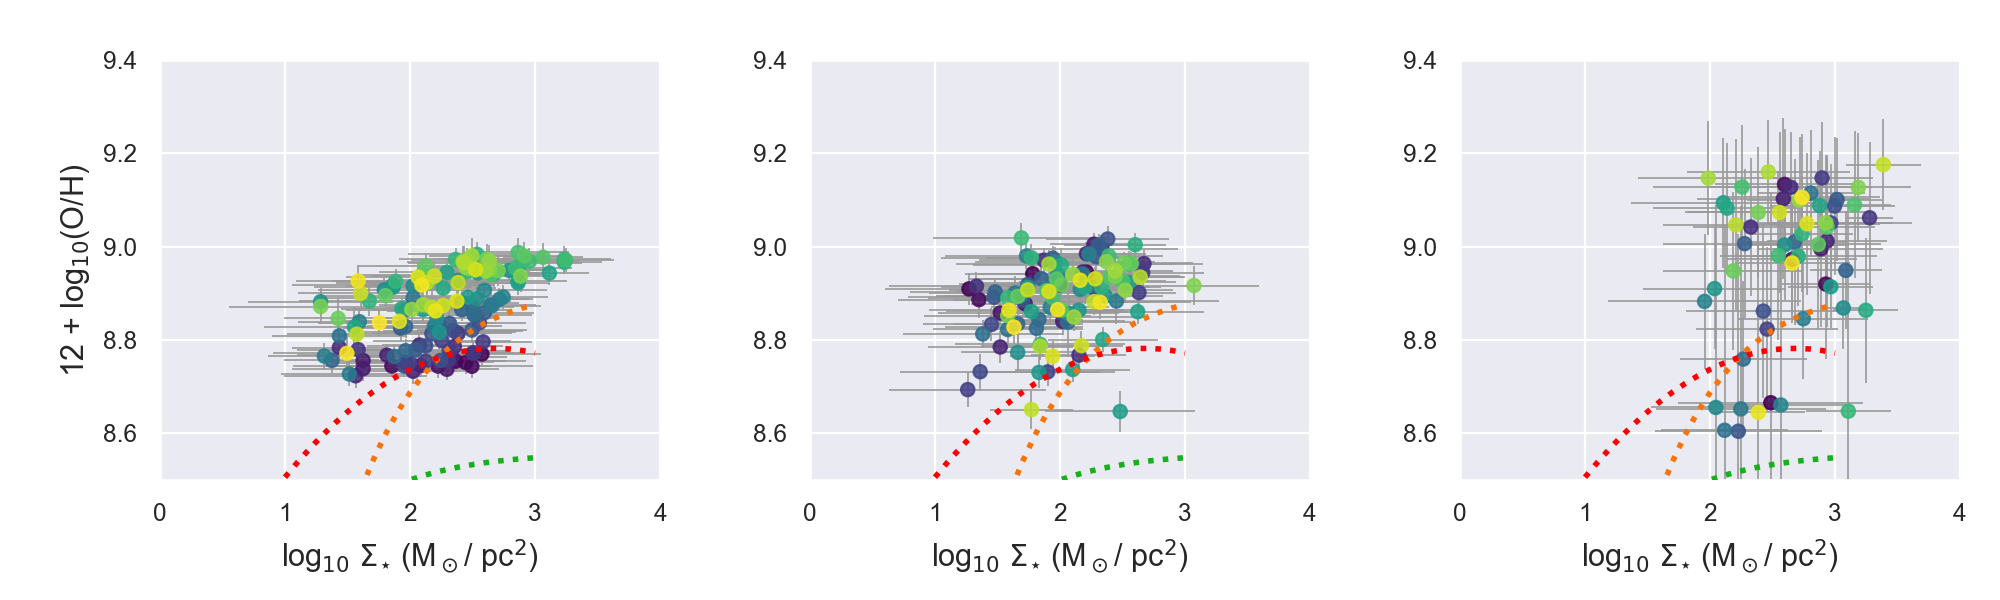

<IPython.core.display.Javascript object>


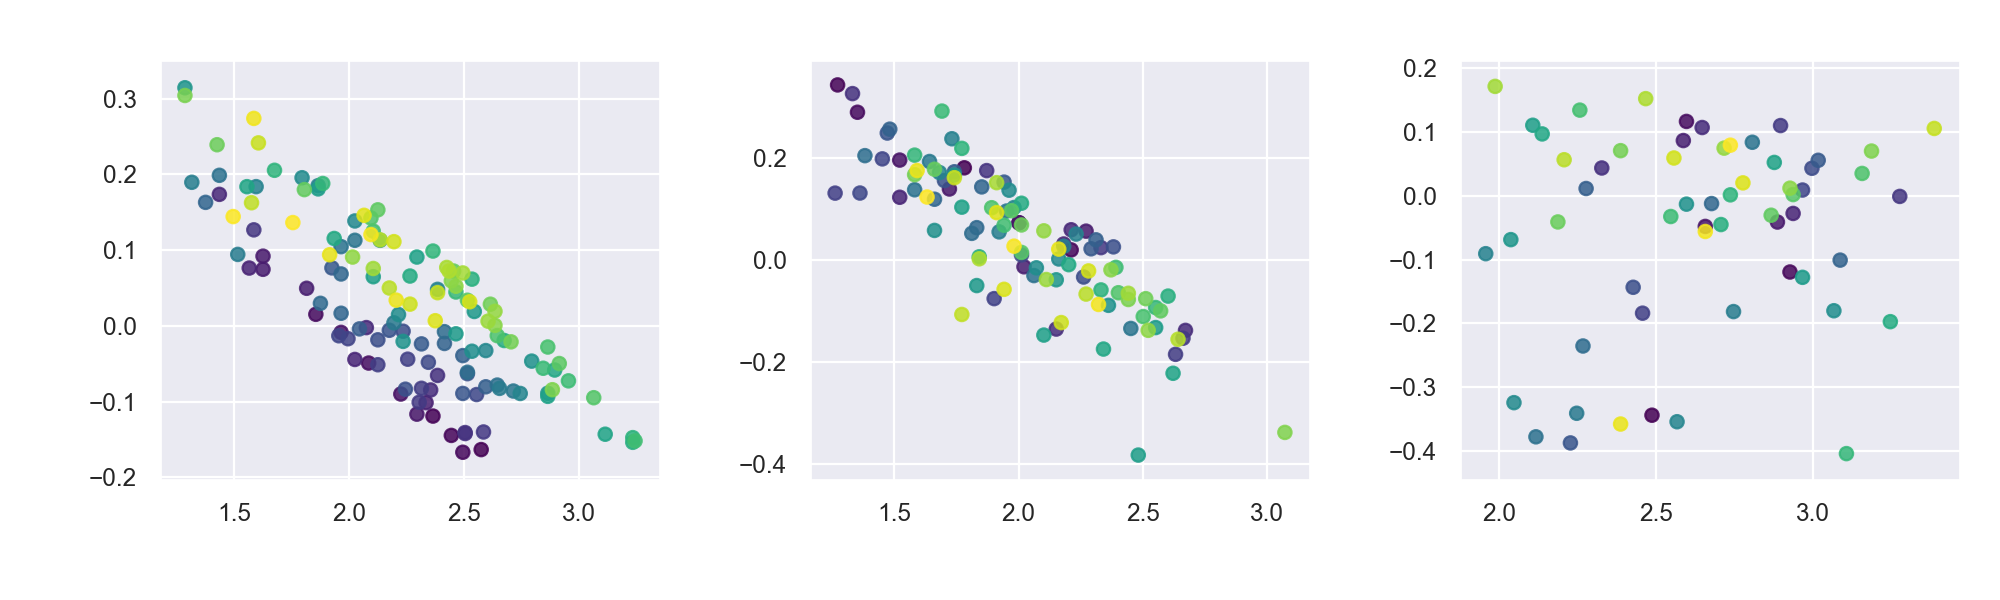

<IPython.core.display.Javascript object>


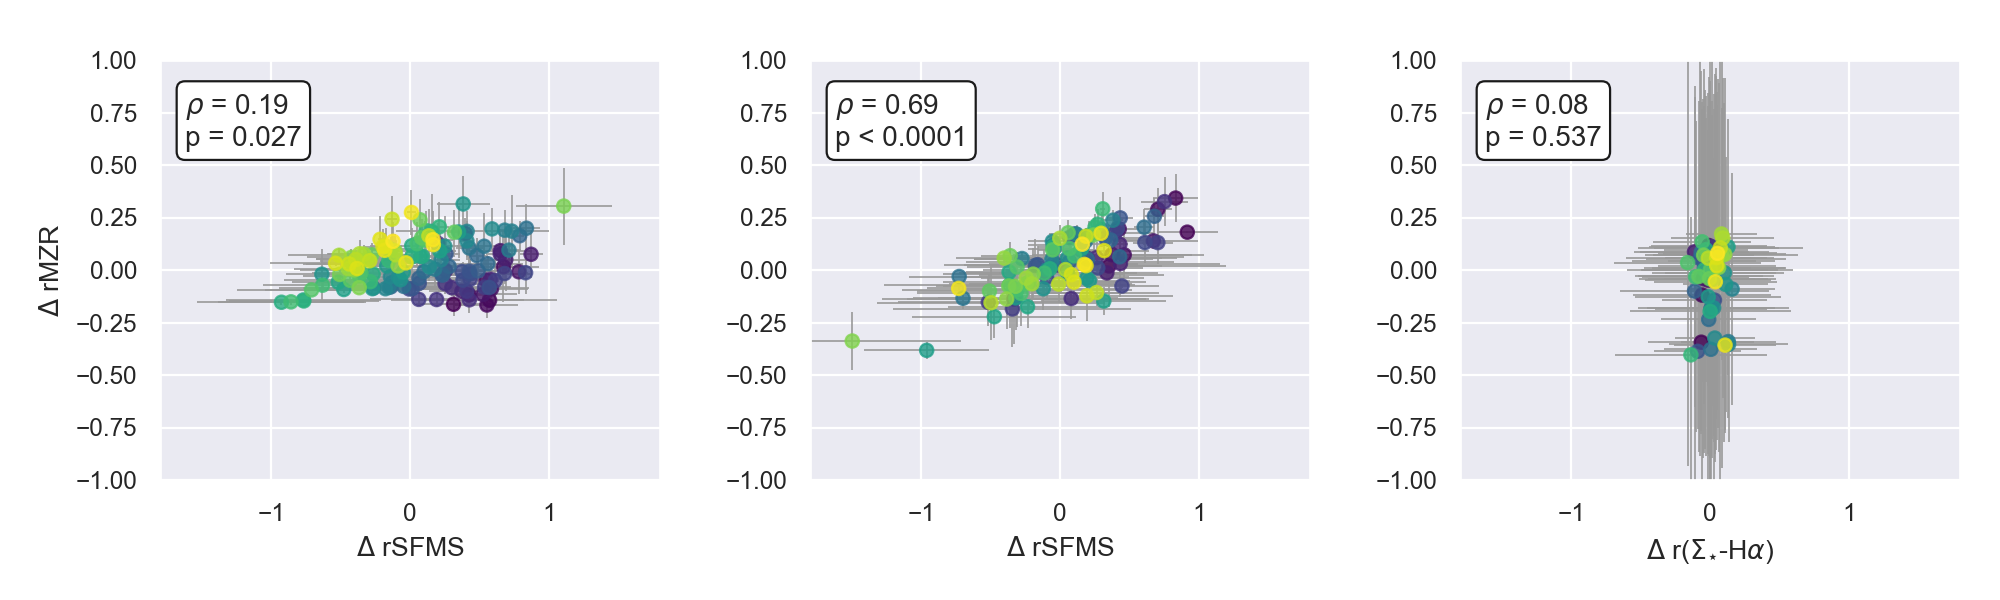

In [142]:
fig, ax = plt.subplots(1,3,figsize=(10,3.2))
fig.subplots_adjust(left=0.08,top=0.90,right=0.98,bottom=0.2,hspace=0.3,wspace=0.3)

## Plot data
ax[0].errorbar(as1063['mass_density'],as1063['sfr_density'],
               xerr = as1063['mass_density_unc'],yerr=as1063['sfr_density_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[0].scatter(as1063['mass_density'],as1063['sfr_density'], linewidths=None, alpha=0.85, marker='o', cmap='viridis', c=range(len(as1063)),zorder=2)
ax[1].errorbar(a370['mass_density'],a370['sfr_density'],
               xerr = a370['mass_density_unc'],yerr=a370['sfr_density_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
cax = ax[1].scatter(a370['mass_density'],a370['sfr_density'], linewidths=None, alpha=0.85, marker='o', cmap='viridis', c=range(len(a370)),zorder=2)

ax[2].errorbar(m1206['mass_density'],m1206['Ha_flux'],
               xerr = m1206['mass_density_unc'],yerr=m1206['Ha_flux_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
cax = ax[2].scatter(m1206['mass_density'],m1206['Ha_flux'], linewidths=None, alpha=0.85, marker='o', cmap='viridis', c=range(len(m1206)),zorder=2)

## Fit
as1063_ms_fit_norm = fit_with_linmix_tests(as1063,ax[0],'mass_density','sfr_density',xs=np.arange(1,3.5,0.1),seed=1014,xnorm=2.0)
a370_ms_fit_norm = fit_with_linmix_tests(a370,ax[1],'mass_density','sfr_density',xs=np.arange(1,3.1,0.1),seed=1016,xnorm=2.0)
m1206_ms_fit_norm = fit_with_linmix_tests(m1206,ax[2],'mass_density','Ha_flux',xs=np.arange(1.5,3.8,0.1),seed=1019,xnorm=2.5)


## Legends and axis
ax[0].set_ylabel('log$_{10}$ $\Sigma_{SFR, H\\beta}$ (M$_\odot$/ yr/ pc$^2$)',fontsize='11')
ax[0].set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')

ax[1].set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')

ax[2].set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')
ax[2].set_ylabel('log$_{10}$ H$\\alpha$ (10$^{-18}$ erg/ cm$^2$/ s$^2$)',labelpad=0,fontsize='11')
ax[2].set_ylim(0.2,1.2)

for x in ax: x.set_xlim(0,4)
for x in ax[:2]: x.set_ylim(-9,-4.5)

ax[0].set_title('AS1063-arc',fontsize=13)    
ax[1].set_title('A370-sys1',fontsize=13)    
ax[2].set_title('M1206-sys1',fontsize=13)    
    
    
    
fig, ax = plt.subplots(1,3,figsize=(10,3.2))
fig.subplots_adjust(left=0.08,top=0.90,right=0.98,bottom=0.2,hspace=0.3,wspace=0.3)

## Plot data
ax[0].scatter(as1063['mass_density'],as1063['ms_res_norm'], linewidths=None, alpha=0.85, marker='o', cmap='viridis', c=range(len(as1063)),zorder=2)
ax[1].scatter(a370['mass_density'],a370['ms_res_norm'], linewidths=None, alpha=0.85, marker='o', cmap='viridis', c=range(len(a370)),zorder=2)
ax[2].scatter(m1206['mass_density'],m1206['ms_res_norm'], linewidths=None, alpha=0.85, marker='o', cmap='viridis', c=range(len(m1206)),zorder=2)

for x in ax: x.set_xlim(0,4)
   
        
    

fig, ax = plt.subplots(1,3,figsize=(10,3))
fig.subplots_adjust(left=0.08,top=0.90,right=0.98,bottom=0.2,hspace=0.3,wspace=0.3)

## Plot data
ax[0].errorbar(as1063['mass_density'],as1063['met'],xerr = as1063['mass_density_unc'],yerr=as1063['met_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[0].scatter(as1063['mass_density'], as1063['met'], linewidths=None, alpha=0.85, marker='o', cmap='viridis', c=range(len(as1063)),zorder=2)
ax[1].errorbar(a370['mass_density'],a370['met'],xerr = a370['mass_density_unc'],yerr=a370['met_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
cax = ax[1].scatter(a370['mass_density'],a370['met'], linewidths=None, alpha=0.85, marker='o', cmap='viridis', c=range(len(a370)),zorder=2)
ax[2].errorbar(m1206['mass_density'],m1206['met'],xerr = m1206['mass_density_unc'],yerr=m1206['met_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[2].scatter(m1206['mass_density'],m1206['met'], linewidths=None, alpha=0.85, marker='o', cmap='viridis', c=range(len(m1206)),zorder=2)


# Plot other works
xs = np.arange(1,3.1,0.1)
for x in ax:
    x.plot(xs,barreraballesteros2016(xs),'#15b01a',linestyle=':',zorder=10,label='Barrera (Manga)',linewidth=2)
    x.plot(xs,sanchez2013(xs),'#f97306',zorder=10,linestyle=':',label='Sanchez (Califa)',linewidth=2)
    x.plot(xs,rosalesortega2012(xs),'red',zorder=10,linestyle=':',label='Rosales (Pings)',linewidth=2)
    

##Legends
ax[0].set_ylabel('12 + log$_{10}$(O/H)',fontsize='11')
for x in ax:
    x.set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')
    x.set_ylim(8.5,9.4)
    x.set_xlim(0,4)
    
    
fig, ax = plt.subplots(1,3,figsize=(10,3))
fig.subplots_adjust(left=0.08,top=0.90,right=0.98,bottom=0.2,hspace=0.3,wspace=0.3)

## Plot data
ax[0].scatter(as1063['mass_density'], as1063['mzr_res_norm'], linewidths=None, alpha=0.85, marker='o', cmap='viridis', c=range(len(as1063)),zorder=2)
cax = ax[1].scatter(a370['mass_density'],a370['mzr_res_norm'], linewidths=None, alpha=0.85, marker='o', cmap='viridis', c=range(len(a370)),zorder=2)
ax[2].scatter(m1206['mass_density'],m1206['mzr_res_norm'], linewidths=None, alpha=0.85, marker='o', cmap='viridis', c=range(len(m1206)),zorder=2)


    
    
fig, ax = plt.subplots(1,3,figsize=(10,3))
fig.subplots_adjust(left=0.08,top=0.90,right=0.98,bottom=0.2,hspace=0.3,wspace=0.3)

## Plot data
ax[0].errorbar(as1063['ms_res_norm'],as1063['mzr_res_norm'],yerr = as1063['mzr_res_norm_unc'],xerr=as1063['ms_res_norm_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[0].scatter(as1063['ms_res_norm'], as1063['mzr_res_norm'], linewidths=None, alpha=0.80, marker='o',zorder=2,
              cmap='viridis', c=range(len(as1063)))

ax[1].errorbar(a370['ms_res_norm'] ,a370['mzr_res_norm'],yerr = a370['mzr_res_norm_unc'],xerr = a370['ms_res_norm_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[1].scatter(a370['ms_res_norm'], a370['mzr_res_norm'], linewidths=None, alpha=0.80, marker='o',zorder=2, 
              cmap='viridis', c=range(len(a370)))

ax[2].errorbar(m1206['ms_res_norm'],m1206['mzr_res_norm'],yerr = m1206['mzr_res_norm_unc'],xerr=m1206['ms_res_norm_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[2].scatter(m1206['ms_res_norm'], m1206['mzr_res_norm'], linewidths=None, alpha=0.80, marker='o',zorder=2,
              cmap='viridis', c=range(len(m1206)))


calculate_spearman(as1063,ax[0])
calculate_spearman(a370,ax[1])
calculate_spearman(m1206,ax[2])

# Legends and all
ax[0].set_xlabel('$\Delta$ rSFMS')
ax[1].set_xlabel('$\Delta$ rSFMS')
ax[2].set_xlabel('$\Delta$ r($\Sigma_{\star}$-H$\\alpha$)')

ax[0].set_ylabel('$\Delta$ rMZR')


for x in ax: x.set_ylim(-1.0,1.0)
for x in ax: x.set_xlim(-1.8,1.8)   

## OLD

Orthoginal Distance Regression (scipy)

In [10]:
def fit_with_ODR(data,ax,xlabel,ylabel,init, xs = np.arange(0,5), annotate=True ):
    
    def func_for_ODR(params, logmass):
        return params[0] + params[1]*logmass

    model = Model(func_for_ODR)

    mydata = RealData(x = data[xlabel],y = data[ylabel], sx = data[xlabel+'_unc'],sy = data[ylabel+'_unc'])
    fit = ODR(mydata, model, beta0=init)
    
    output = fit.run()
    output.pprint()
    
    ax.plot(xs, output.beta[0] + output.beta[1]*xs , color='0.1')
    bbox_props = dict(boxstyle="round", fc='w',ec="0.1", alpha=1)
    if annotate: 
        ax.annotate('%0.2f$\pm$%0.2f + %0.2f$\pm$%0.2f log($\Sigma_{\star}$)'
                %(output.beta[0],output.sd_beta[0],output.beta[1],output.sd_beta[1]),
                xy=(0.05, 0.85), xycoords='axes fraction',bbox=bbox_props,zorder=20)
    return output

In [36]:
def calculate_residuals_ODR(data,odr_fit):
    alpha, beta = odr_fit.beta
    return data['met'] - (alpha + beta*data['mass_density'])

def calculate_residuals_ODR_error(data,odr_fit):
    alpha, beta = odr_fit.beta
    alpha_err, beta_err = odr_fit.sd_beta
    return data['met_unc'] + alpha_err + data['mass_density']*beta_err + beta*data['mass_density_unc']
    

as1063['odr_res'] =  calculate_residuals_ODR(as1063,as1063_fit_odr)
as1063['odr_res_unc'] =  calculate_residuals_ODR_error(as1063,as1063_fit_odr)
a370['odr_res'] = calculate_residuals_ODR(a370,a370_fit_odr)
a370['odr_res_unc'] = calculate_residuals_ODR_error(a370,a370_fit_odr)
m1206['odr_res'] = calculate_residuals_ODR(m1206,m1206_fit_odr)
m1206['odr_res_unc'] = calculate_residuals_ODR_error(m1206,m1206_fit_odr)

<IPython.core.display.Javascript object>


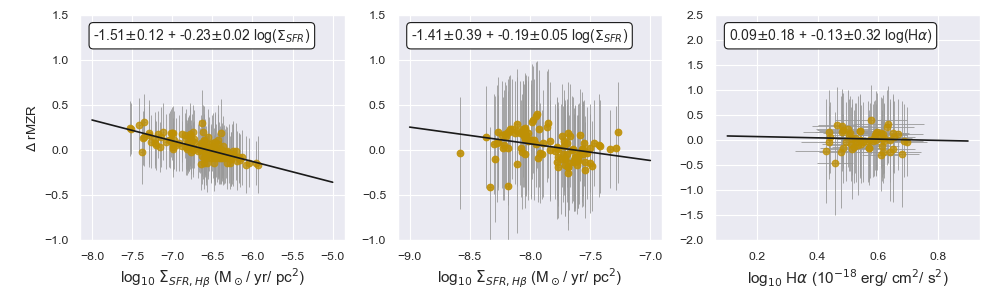

Beta: [-1.51082198 -0.2305249 ]
Beta Std Error: [0.11980586 0.01799779]
Beta Covariance: [[0.25188403 0.03778963]
 [0.03778963 0.00568438]]
Residual Variance: 0.0569843386532
Inverse Condition #: 0.00075779022558
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-1.41413674 -0.18538466]
Beta Std Error: [0.3916082  0.04999184]
Beta Covariance: [[2.47405922 0.31563912]
 [0.31563912 0.04031854]]
Residual Variance: 0.0619859793681
Inverse Condition #: 0.000441760928781
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.09346231 -0.12622618]
Beta Std Error: [0.1825275  0.32162549]
Beta Covariance: [[ 0.71786488 -1.25599082]
 [-1.25599082  2.22888163]]
Residual Variance: 0.0464102516091
Inverse Condition #: 0.0181037050186
Reason(s) for Halting:
  Sum of squares convergence


In [55]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
fig.subplots_adjust(left=0.08,top=0.95,right=0.98,bottom=0.2,hspace=0.3)


## Plot data
ax[0].errorbar(as1063['sfr_density'],as1063['odr_res'],xerr = as1063['sfr_density_unc'],yerr=as1063['odr_res_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[0].scatter(as1063['sfr_density'], as1063['odr_res'], linewidths=None, alpha=0.8,color='#bf9005', marker='o',zorder=2)

ax[1].errorbar(a370['sfr_density'] ,a370['odr_res'],xerr = a370['sfr_density_unc'],yerr = a370['odr_res_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[1].scatter(a370['sfr_density'], a370['odr_res'], linewidths=None, alpha=0.9,color='#bf9005', marker='o',zorder=2)

ax[2].errorbar(m1206['Ha_flux'],m1206['odr_res'],xerr = m1206['Ha_flux_unc'],yerr=m1206['odr_res_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[2].scatter(m1206['Ha_flux'], m1206['odr_res'], linewidths=None, alpha=0.8, marker='o',color='#bf9005',zorder=2)


# Fit data
as1063_res_fit_odr = fit_with_ODR(as1063,ax[0],'sfr_density','odr_res',init=(0,1),xs=np.arange(-8,-4), annotate=False)
a370_res_fit_odr = fit_with_ODR(a370,ax[1],'sfr_density','odr_res',init=(0,1),xs=np.arange(-9,-6), annotate=False)
m1206_res_fit_odr = fit_with_ODR(m1206,ax[2],'Ha_flux','odr_res',init=(0,1),xs=np.arange(0.1,1,0.1), annotate=False)

# Add annotation
bbox_props = dict(boxstyle="round", fc='w',ec="k", alpha=1)
def annotate_fit(ax,output): 
    ax.annotate('%0.2f$\pm$%0.2f + %0.2f$\pm$%0.2f log($\Sigma_{SFR}$)'
            %(output.beta[0],output.sd_beta[0],output.beta[1],output.sd_beta[1]),
            xy=(0.05, 0.89), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)
annotate_fit(ax[0],as1063_res_fit_odr)
annotate_fit(ax[1],a370_res_fit_odr)
ax[2].annotate('%0.2f$\pm$%0.2f + %0.2f$\pm$%0.2f log(H$\\alpha$)'
            %(m1206_res_fit_odr.beta[0],m1206_res_fit_odr.sd_beta[0],m1206_res_fit_odr.beta[1],m1206_res_fit_odr.sd_beta[1]),
            xy=(0.05, 0.89), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)
               
               
# Legends and all
ax[0].set_xlabel('log$_{10}$ $\Sigma_{SFR, H\\beta}$ (M$_\odot$/ yr/ pc$^2$)',fontsize='11')
ax[1].set_xlabel('log$_{10}$ $\Sigma_{SFR, H\\beta}$ (M$_\odot$/ yr/ pc$^2$)',fontsize='11')
ax[2].set_xlabel('log$_{10}$ H$\\alpha$ (10$^{-18}$ erg/ cm$^2$/ s$^2$)',fontsize='11')

ax[0].set_ylabel('$\Delta$ rMZR')

ax[0].set_ylim(-1,1.5)
ax[1].set_ylim(-1,1.5)
ax[2].set_ylim(-2,2.5)

fig.savefig('../Plots/res_rMZR_vs_SFR.pdf')

## Try both on the same plot

<IPython.core.display.Javascript object>


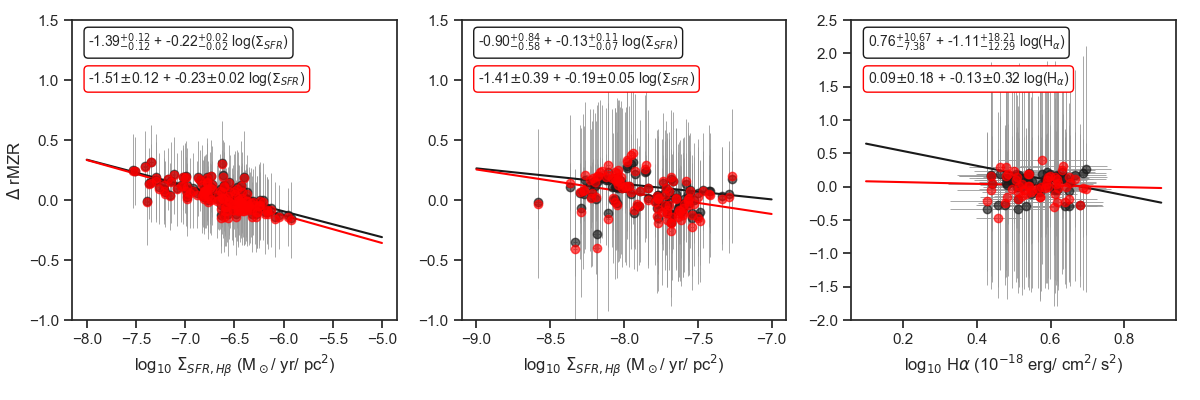

<IPython.core.display.Javascript object>


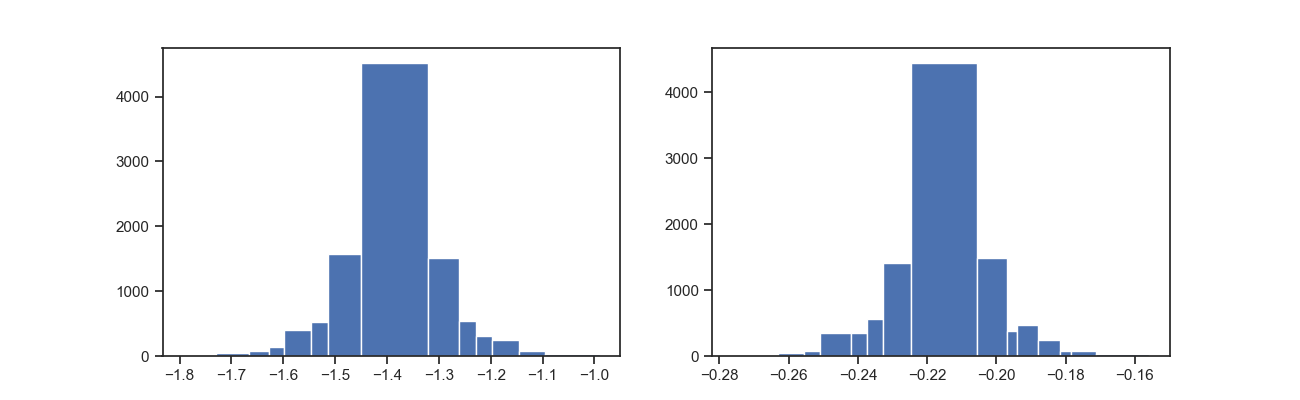

<IPython.core.display.Javascript object>


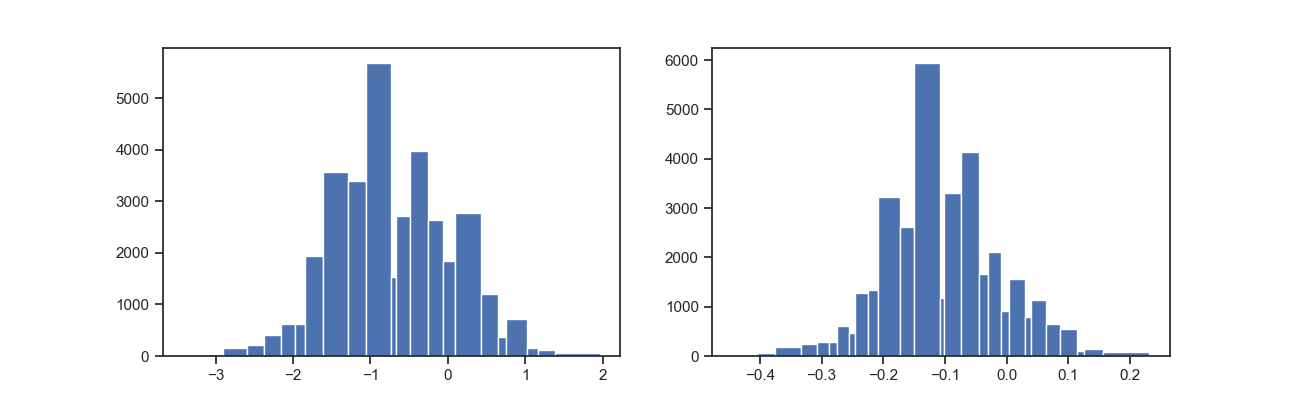

<IPython.core.display.Javascript object>


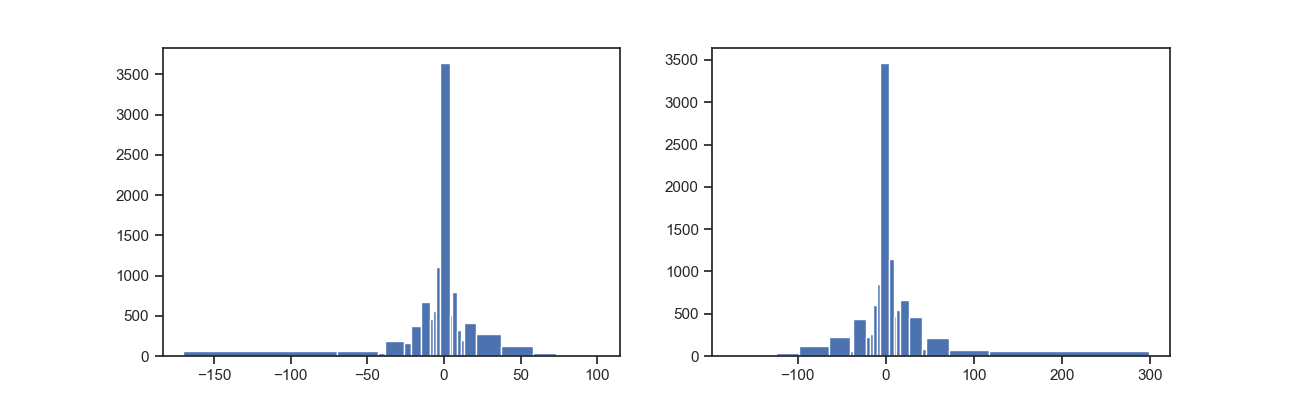

Beta: [-1.51082218 -0.23052493]
Beta Std Error: [0.11980585 0.01799779]
Beta Covariance: [[0.25188398 0.03778962]
 [0.03778962 0.00568438]]
Residual Variance: 0.0569843386532
Inverse Condition #: 0.00075779030938
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-1.41413688 -0.18538468]
Beta Std Error: [0.39160835 0.04999186]
Beta Covariance: [[2.47406105 0.31563935]
 [0.31563935 0.04031857]]
Residual Variance: 0.0619859793681
Inverse Condition #: 0.000441760771778
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 0.09350184 -0.12629633]
Beta Std Error: [0.18252755 0.32162556]
Beta Covariance: [[ 0.71786521 -1.25599138]
 [-1.25599138  2.22888259]]
Residual Variance: 0.0464102516045
Inverse Condition #: 0.0181037024863
Reason(s) for Halting:
  Sum of squares convergence


In [46]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
fig.subplots_adjust(left=0.06,top=0.95,right=0.98,bottom=0.2,hspace=0.25)

## Plot data linmix
ax[0].errorbar(as1063['sfr_density'],as1063['linmix_res'],xerr = as1063['sfr_density_unc'],yerr=as1063['linmix_res_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[0].scatter(as1063['sfr_density'], as1063['linmix_res'], linewidths=None, alpha=0.65, marker='o',zorder=10,color='k')

ax[1].errorbar(a370['sfr_density'] ,a370['linmix_res'],xerr = a370['sfr_density_unc'],yerr = a370['linmix_res_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[1].scatter(a370['sfr_density'], a370['linmix_res'], linewidths=None, alpha=0.65, marker='o',zorder=10,color='k')

ax[2].errorbar(m1206['Ha_flux'],m1206['linmix_res'],xerr = m1206['Ha_flux_unc'],yerr=m1206['linmix_res_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[2].scatter(m1206['Ha_flux'], m1206['linmix_res'], linewidths=None, alpha=0.65, marker='o',zorder=10,color='k')



## Plot data odr
ax[0].errorbar(as1063['sfr_density'],as1063['odr_res'],xerr = as1063['sfr_density_unc'],yerr=as1063['odr_res_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[0].scatter(as1063['sfr_density'], as1063['odr_res'], linewidths=None, alpha=0.65, marker='o',zorder=10,color='red')

ax[1].errorbar(a370['sfr_density'] ,a370['odr_res'],xerr = a370['sfr_density_unc'],yerr = a370['odr_res_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[1].scatter(a370['sfr_density'], a370['odr_res'], linewidths=None, alpha=0.65, marker='o',zorder=10,color='red')

ax[2].errorbar(m1206['Ha_flux'],m1206['odr_res'],xerr = m1206['Ha_flux_unc'],yerr=m1206['odr_res_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[2].scatter(m1206['Ha_flux'], m1206['odr_res'], linewidths=None, alpha=0.65, marker='o',zorder=10,color='red')



# Fit data
as1063_res_fit_linmix = fit_with_linmix(as1063,ax[0],'sfr_density','linmix_res',xs=np.arange(-8,-4), annotate=False)
a370_res_fit_linmix = fit_with_linmix(a370,ax[1],'sfr_density','linmix_res',xs=np.arange(-9,-6), annotate=False)
m1206_res_fit_linmix = fit_with_linmix(m1206,ax[2],'Ha_flux','linmix_res',xs=np.arange(0.1,1,0.1), annotate=False)

as1063_res_fit_odr = fit_with_ODR(as1063,ax[0],'sfr_density','odr_res',init=(0,-1),xs=np.arange(-8,-4), annotate=False)
a370_res_fit_odr = fit_with_ODR(a370,ax[1],'sfr_density','odr_res',init=(0,-1),xs=np.arange(-9,-6), annotate=False)
m1206_res_fit_odr = fit_with_ODR(m1206,ax[2],'Ha_flux','odr_res',init=(0,-1),xs=np.arange(0.1,1,0.1), annotate=False)


# Add annotation
bbox_props = dict(boxstyle="round", fc='w',ec="k", alpha=1)
def annotate_fit(ax,fit):
    alpha_best,alpha_low,alpha_high,beta_best,beta_low,beta_high = fit
    ax.annotate('%0.2f$^{+%0.2f}_{-%0.2f}$ + %0.2f$^{+%0.2f}_{-%0.2f}$ log($\Sigma_{SFR}$)'
                %(alpha_best,alpha_high-alpha_best,alpha_best-alpha_low,beta_best,beta_high-beta_best,beta_best-beta_low),
                 xy=(0.05, 0.91), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)   
annotate_fit(ax[0],as1063_res_fit_linmix)
annotate_fit(ax[1],a370_res_fit_linmix)
alpha_best,alpha_low,alpha_high,beta_best,beta_low,beta_high = m1206_res_fit_linmix
ax[2].annotate('%0.2f$^{+%0.2f}_{-%0.2f}$ + %0.2f$^{+%0.2f}_{-%0.2f}$ log(H$_\\alpha$)'
                %(alpha_best,alpha_high-alpha_best,alpha_best-alpha_low,beta_best,beta_high-beta_best,beta_best-beta_low),
                 xy=(0.05, 0.91), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)


# Add annotation
bbox_props = dict(boxstyle="round", fc='w',ec="red", alpha=1)
def annotate_fit(ax,output): 
    ax.annotate('%0.2f$\pm$%0.2f + %0.2f$\pm$%0.2f log($\Sigma_{SFR}$)'
            %(output.beta[0],output.sd_beta[0],output.beta[1],output.sd_beta[1]),
            xy=(0.05, 0.79), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)
annotate_fit(ax[0],as1063_res_fit_odr)
annotate_fit(ax[1],a370_res_fit_odr)
ax[2].annotate('%0.2f$\pm$%0.2f + %0.2f$\pm$%0.2f log(H$_\\alpha$)'
            %(m1206_res_fit_odr.beta[0],m1206_res_fit_odr.sd_beta[0],m1206_res_fit_odr.beta[1],m1206_res_fit_odr.sd_beta[1]),
            xy=(0.05, 0.79), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)


# Legends and all
ax[0].set_xlabel('log$_{10}$ $\Sigma_{SFR, H\\beta}$ (M$_\odot$/ yr/ pc$^2$)')
ax[1].set_xlabel('log$_{10}$ $\Sigma_{SFR, H\\beta}$ (M$_\odot$/ yr/ pc$^2$)')
ax[2].set_xlabel('log$_{10}$ H$\\alpha$ (10$^{-18}$ erg/ cm$^2$/ s$^2$)')

ax[0].set_ylabel('$\Delta$ rMZR')

ax[0].set_ylim(-1,1.5)
ax[1].set_ylim(-1,1.5)
ax[2].set_ylim(-2,2.5)


fig.savefig('../Plots/res_rMZR_vs_SFR.pdf')

**With SFR from SED fitting**

<IPython.core.display.Javascript object>


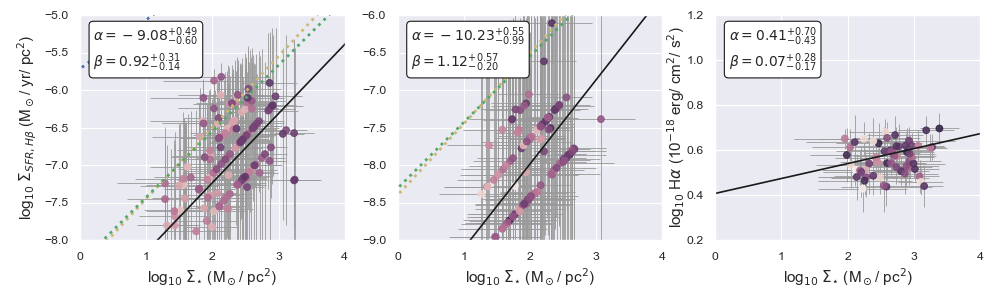

<IPython.core.display.Javascript object>


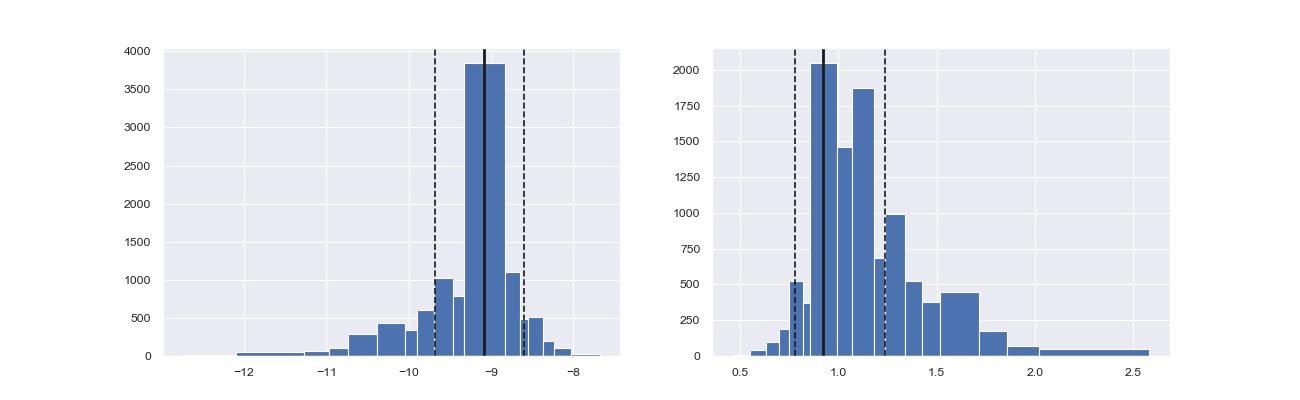

Intrinsic scatter 0.04280725279745722


<IPython.core.display.Javascript object>


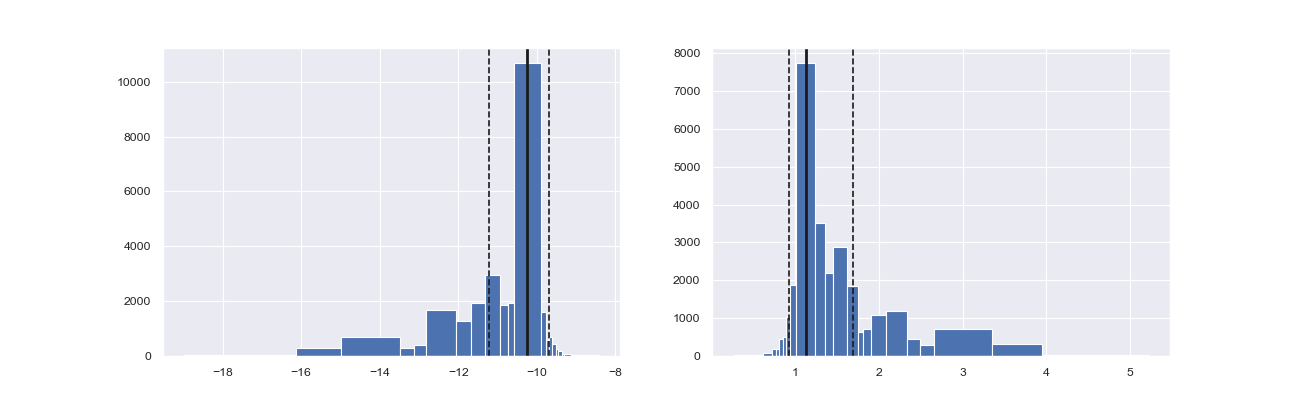

Intrinsic scatter 0.015224182689732059


<IPython.core.display.Javascript object>


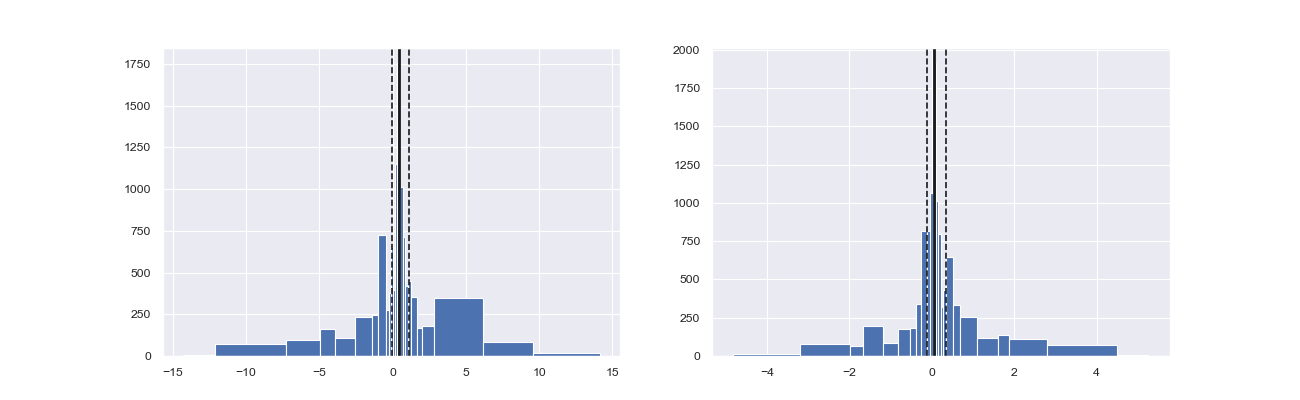

Intrinsic scatter 0.000819719244137257


(0.2, 1.2)

In [11]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
fig.subplots_adjust(left=0.08,top=0.95,right=0.98,bottom=0.2,hspace=0.3)

## Plot data
ax[0].errorbar(as1063['mass_density'],as1063['sfr_density_SED'],
               xerr = as1063['mass_density_unc'],yerr=as1063['sfr_density_SED_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
ax[0].scatter(as1063['mass_density'],as1063['sfr_density_SED'], linewidths=None, alpha=0.85, marker='o', cmap=cmap_met, c=as1063['met'],zorder=2,vmin=8.65, vmax=9.05)
ax[1].errorbar(a370['mass_density'],a370['sfr_density_SED'],
               xerr = a370['mass_density_unc'],yerr=a370['sfr_density_SED_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
cax = ax[1].scatter(a370['mass_density'],a370['sfr_density_SED'], linewidths=None, alpha=0.85, marker='o', cmap=cmap_met, c=a370['met'],zorder=2,vmin=8.65, vmax=9.05)

ax[2].errorbar(m1206['mass_density'],m1206['Ha_flux'],
               xerr = m1206['mass_density_unc'],yerr=m1206['Ha_flux_unc'],
               marker='',linestyle='', ecolor='0.6', elinewidth=0.6)
cax = ax[2].scatter(m1206['mass_density'],m1206['Ha_flux'], linewidths=None, alpha=0.85, marker='o', cmap=cmap_met, c=m1206['met'],zorder=2)
#plt.colorbar(cax,ax=ax[2],label='12+log(O/H)')


## Fit
as1063_sed_limix_fit = fit_with_linmix(as1063,ax[0],'mass_density','sfr_density')
a370_sed_limix_fit = fit_with_linmix(a370,ax[1],'mass_density','sfr_density')
m1206_sed_limix_fit = fit_with_linmix(m1206,ax[2],'mass_density','Ha_flux')

# Other published works
xs = np.arange(-3,5)
for x in ax[:2] :
    x.plot(xs,wuytz2013(xs),'y',zorder=10,label='Wuytz 2013',linestyle=':',linewidth=2)
    x.plot(xs,abdurrouf2018(xs),'g',zorder=10,label='Abdurro\'uf 2018',linestyle=':',linewidth=2)
    x.plot(xs,speagle2014(xs,t = 7.206),'b',zorder=10,label='Speagle 2014',linestyle=':',linewidth=2)

## Legends and axis
ax[0].set_ylabel('log$_{10}$ $\Sigma_{SFR, H\\beta}$ (M$_\odot$/ yr/ pc$^2$)',fontsize='11')
ax[0].set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')
ax[0].set_ylim(-8.0,-5.0)
ax[0].set_xlim(0,4)

ax[1].set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')
ax[1].set_ylim(-9.0,-6.0)
ax[1].set_xlim(0,4)

ax[2].set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ pc$^2$)',fontsize='11')
ax[2].set_ylabel('log$_{10}$ H$\\alpha$ (10$^{-18}$ erg/ cm$^2$/ s$^2$)',labelpad=0,fontsize='11')

ax[2].set_xlim(0,4)
ax[2].set_ylim(0.2,1.2)

#fig.savefig('../Plots/rSFMS.pdf')